### Load Libraries and Set Seeds

In [1]:
# !pip install mplsoccer
# !pip install altair
# !pip install utils
# !pip install xgboost
# !pip install shap
# !brew install graphviz

from mplsoccer import Sbopen, Pitch
from statsbombpy import sb

import pandas as pd
import numpy as np
import warnings 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import random as rn
import tensorflow as tf
import time
from multiprocessing import Pool

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import graphviz

pd.options.display.max_columns = None
# pd.options.display.max_rows = None

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss, log_loss, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif, chi2
from sklearn import tree

from xgboost import XGBClassifier
from pathlib import Path

In [2]:
# For reproducibility, setting seeds
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

### Helper Methods: Gather, Clean Data; Add New Metrics; Standardise Features, Targets

In [3]:
competitions_df = sb.competitions()
def gather_data(ids_list):
    start_time = time.time()

    parser = Sbopen()
    
    event_df = pd.DataFrame()
    related_df = pd.DataFrame()
    frames_df = pd.DataFrame()

    for comp_id, seas_id in ids_list:
        # Get all matches and store their ids
        df_match = parser.match(competition_id=comp_id, season_id=seas_id)
        matches = df_match.match_id.unique()
        print(f"Matches : {len(matches)}")

        # Get tracking 360 data for the particular season
        comp_row = competitions_df[(competitions_df["season_id"] == seas_id) & (competitions_df["competition_id"] == comp_id)].iloc[0]
        df_frames = sb.competition_frames(country=comp_row["country_name"], division=comp_row["competition_name"], season=comp_row["season_name"], gender=comp_row["competition_gender"])
        frames_df = pd.concat([frames_df, df_frames], ignore_index=True)
        
        for match in matches:

            # Open events
            df_event, df_related, _, _ = parser.event(match)
            df_event["comp_id"] = comp_id
            df_event["seas_id"] = seas_id

            # Append event and trackings to a dataframe
            event_df = pd.concat([event_df, df_event], ignore_index=True)
            related_df = pd.concat([related_df, df_related], ignore_index=True)

    #reset indices    
    event_df.reset_index(drop=True, inplace=True) 
    event_df.dropna(axis=1, how='all', inplace=True)
    
    pass_df = event_df.loc[event_df['type_name'] == 'Pass'].reset_index(drop=True).copy(deep=True)
    pass_df.dropna(axis=1, how='all', inplace=True)

    related_df.reset_index(drop=True, inplace=True) 
    related_df.dropna(axis=1, how='all', inplace=True)

    frames_df.reset_index(drop=True, inplace=True) 
    frames_df.dropna(axis=1, how='all', inplace=True)
    frames_df[['x', 'y']] = pd.DataFrame(frames_df['location'].tolist(), index=frames_df.index)
    frames_df.drop(columns=['location'], inplace=True)

    print(f"Data Gathering completed in: {round(time.time() - start_time, 2)}s")
    return  pass_df, event_df, related_df, frames_df

In [4]:
def clean_passes(pass_df, frames_df):
    clean_pass_df = pass_df[pass_df["id"].isin(set(frames_df["event_uuid"]))]
    return clean_pass_df

In [5]:
def player_within_distances(df, frames_df):
    start_time = time.time()
    results = []

    # Group frames_df by event_uuid and match_id
    grouped_frames = frames_df[frames_df['teammate'] == False].groupby(['event_uuid', 'match_id'])

    for _, pass_row in df.iterrows():
        row_pass_id = pass_row["id"]
        row_match_id = pass_row["match_id"]
        
        try:
            player_positions = grouped_frames.get_group((row_pass_id, row_match_id))
            y_diff = pass_row["y"] - player_positions["y"].values
            x_diff = pass_row["x"] - player_positions["x"].values
            distances = np.sqrt(x_diff**2 + y_diff**2)
            
            counts = [np.sum(distances < d) for d in [1, 2, 3]]
            results.append(tuple(counts))
            
        except KeyError:
            results.append((0, 0, 0))

    return results

In [6]:
def vectorized_distance_from_point_to_line(line_starts, line_ends, points):
    x1, y1 = line_starts[:, 0], line_starts[:, 1]
    x2, y2 = line_ends[:, 0], line_ends[:, 1]
    A = y2 - y1
    B = x1 - x2
    C = x2 * y1 - x1 * y2
    
    # Reshape A, B, C to allow broadcasting
    A = A[:, np.newaxis]
    B = B[:, np.newaxis]
    C = C[:, np.newaxis]
    
    # Ensure points is a 3D array
    if points.ndim == 2:
        points = points[:, np.newaxis, :]

    distances = np.abs(A * points[..., 0] + B * points[..., 1] + C) / np.sqrt(A**2 + B**2)
    return distances


def vectorized_avg_defender_distance(df, opposition_positions):
    pass_starts = df[['x', 'y']].values
    pass_ends = df[['end_x', 'end_y']].values
    pass_ids = df['id'].values
    
    # Create an array to store the minimum distances
    avg_distances = np.full(len(df), 72.0)
    
    # Get opposition positions for each pass
    opp_positions = [np.array(opposition_positions.get(pid, [])) for pid in pass_ids]
    
    # Filter out passes with no opposition players
    valid_indices = [i for i, pos in enumerate(opp_positions) if pos.size > 0]
    
    if valid_indices:
        valid_starts = pass_starts[valid_indices]
        valid_ends = pass_ends[valid_indices]
        valid_positions = [opp_positions[i] for i in valid_indices]
        
        # Calculate distances
        distances = [vectorized_distance_from_point_to_line(start[np.newaxis], end[np.newaxis], pos)
                     for start, end, pos in zip(valid_starts, valid_ends, valid_positions)]
        
        # Get average distances
        avg_distances[valid_indices] = [np.average(d) for d in distances]
    
    return avg_distances

In [7]:
def create_new_metrics(clean_pass_df, frames_df):
    start_time = time.time()
    model_vars = pd.DataFrame()
    results = player_within_distances(clean_pass_df, frames_df)
    model_vars[['num_1_away', 'num_2_away', 'num_3_away']] = pd.DataFrame(results, index=clean_pass_df.index)
    print(f"Player_within_distances completed in {round(time.time() - start_time, 2)}s")
    
    start_time = time.time()
    opposition_positions = frames_df[frames_df['teammate'] == False].groupby('event_uuid').apply(lambda g: g[['x', 'y']].values).to_dict()
    model_vars['avg_defender_distance'] = vectorized_avg_defender_distance(clean_pass_df, opposition_positions)
    model_vars = model_vars.dropna(subset=["avg_defender_distance"])
    clean_pass_df = clean_pass_df.loc[model_vars.index]
    print(f"Closest_defender_passing_line completed in {round(time.time() - start_time, 2)}s")
    
    return model_vars, clean_pass_df

In [8]:
def standardise_features(df):
    try:
        df["is_under_pressure"] = np.where(df["under_pressure"].isnull(), 0, 1)
        df.drop(columns=["under_pressure"], axis=1, inplace=True)
        df.rename(columns={"is_under_pressure":"under_pressure"}, inplace=True)
    except:
        print("no under pressure")
    df.fillna(0, inplace=True)
    object_columns = df.select_dtypes(include=['object']).columns
    df[object_columns] = df[object_columns].astype(int)
    assert list(df.select_dtypes(include=['object']).columns) == []
    return df

In [9]:
def standardise_target(df):
    df["pass_outcome"] = np.where(df["outcome_id"].isnull(), 1, 0)
    df.drop(columns=["outcome_id"], axis=1, inplace=True)
    df.rename(columns={"pass_outcome":"outcome_id"}, inplace=True)
    return df

### Gather Training Data

In [10]:
# Women's world cup ((72, 107)) + Euros 2020 and 2024 + Bayer Leverkusen 23/24 
train_ids = [(55,43), (9,281), (72, 107)]
test_ids = [(55,282)]

# Get the data
pass_df, event_df, related_df, frames_df = gather_data(train_ids)

Matches : 51


/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not

Matches : 34


/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not

Matches : 64


/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not

Data Gathering completed in: 366.43s


### Clean Training Data

In [11]:
# Only store those rows that have corresponding 360 entry in frames_df
clean_pass_df = clean_passes(pass_df, frames_df)
print(f"Data lost from cleaning pass_df: {round((1 - len(clean_pass_df) / len(pass_df))*100.0, 2)}%")

new_metrics_df, clean_pass_df = create_new_metrics(clean_pass_df, frames_df)
# Add new metrics to our main_df
clean_pass_df = pd.concat([clean_pass_df, new_metrics_df], axis=1)

Data lost from cleaning pass_df: 14.87%
Player_within_distances completed in 25.83s


/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/4125588332.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  opposition_positions = frames_df[frames_df['teammate'] == False].groupby('event_uuid').apply(lambda g: g[['x', 'y']].values).to_dict()
/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/2822652700.py:17: RuntimeWarning: invalid value encountered in divide
  distances = np.abs(A * points[..., 0] + B * points[..., 1] + C) / np.sqrt(A**2 + B**2)


Closest_defender_passing_line completed in 80.5s


### Create Training Variables and Features

In [12]:
# What I think are the basic features that should be included to predict pass completion
basic_features = ['play_pattern_id', 'pass_length', 'pass_angle', 'pass_height_id',
       'end_x', 'end_y', 'body_part_id', 'sub_type_id', 'x', 'y', 'under_pressure']

# All features in the model (only excludes target variablem, "*_name" counterparts of "*_id", and match timing details)
all_features = ['duration', 'pass_length', 'pass_angle', 'pass_height_id', 'end_x', 'end_y', 'body_part_id', 'sub_type_id', 'x', 'y', 
                'under_pressure', 'technique_id', 'off_camera', 'counterpress', 'out', 'num_1_away', 'num_2_away', 
                'num_3_away', 'avg_defender_distance', 'aerial_won', 'pass_cross', 'pass_switch', 'pass_shot_assist',
                'pass_goal_assist', 'pass_cut_back', 'pass_deflected', 'pass_no_touch', 'pass_miscommunication', 'play_pattern_id']

# Features that were manually created
created_features = ['num_3_away', 'num_2_away', 'num_1_away', 'avg_defender_distance']

# Features that were considered statistically important by RF, Permutation Importance, Chi2, and Mutual Info
imp_features = ['pass_height_id', 'pass_length',  'pass_angle', 'duration', 'x', 'y', 'end_x', 'end_y', 'body_part_id', 
                      'sub_type_id', 'aerial_won', 'avg_defender_distance', 'num_1_away']


features = {"basic" : (basic_features + created_features),
            "imp" : imp_features,
            "all" : all_features
           }

In [13]:
#store dependent variable 
y = clean_pass_df["outcome_id"].to_frame()
y = standardise_target(y)

#store independent variables
X_basic = clean_pass_df[features["basic"]]
X_basic = standardise_features(X_basic)

X_imp = clean_pass_df[features["imp"]]
X_imp = standardise_features(X_imp)

X_all = clean_pass_df[features["all"]]
X_all = standardise_features(X_all)

X_dict = {"basic":X_basic, "imp":X_imp, "all":X_all}

no under pressure


/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/2834275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_under_pressure"] = np.where(df["under_pressure"].isnull(), 0, 1)
/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/2834275.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["under_pressure"], axis=1, inplace=True)
/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/2834275.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

### Feature Selection and Importance

RandomForest fitted in: 25.135199785232544s
#####################
Random Forest Inate Importances duration                 0.153841
pass_height_id           0.136277
pass_length              0.106737
end_x                    0.100325
pass_angle               0.094499
end_y                    0.088424
num_3_away               0.066346
x                        0.065766
y                        0.056519
pass_miscommunication    0.025106
pass_switch              0.018147
body_part_id             0.018145
sub_type_id              0.013667
num_2_away               0.011568
aerial_won               0.010027
num_1_away               0.008123
play_pattern_id          0.006231
under_pressure           0.004540
out                      0.003658
pass_cross               0.003218
pass_shot_assist         0.003118
avg_defender_distance    0.002150
pass_no_touch            0.001445
counterpress             0.000573
off_camera               0.000556
pass_cut_back            0.000301
pass_goal_assist  

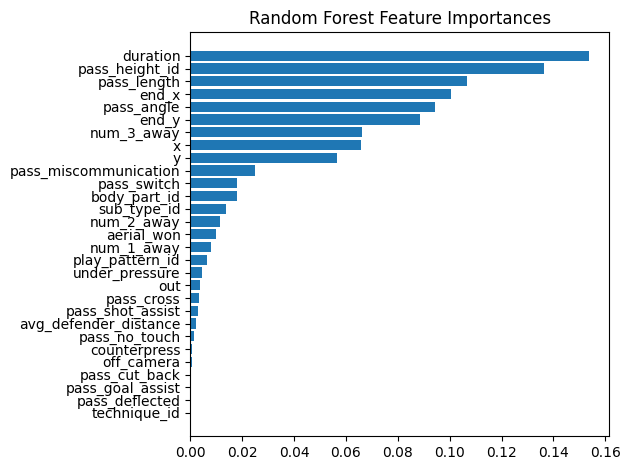

In [14]:
# Feature Importance
X_train, X_test, y_train, y_test = train_test_split(X_all, y, train_size = 0.7, random_state = 123, stratify = y)
start_time = time.time()
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
print(f"RandomForest fitted in: {time.time() -start_time}s")

importances = rf.feature_importances_
rf_importances = pd.Series(importances, index=all_features).sort_values(ascending=False)
print("#####################\nRandom Forest Inate Importances", rf_importances, "\n#####################\n")
# std = np.std([rf.feature_importances_ for tree in rf.estimators_], axis=0)
# fig, ax = plt.subplots()
# rf_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using Random Forest")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()
# plt.show()
print("#####################")
scores = rf_importances.sort_values()
width = np.arange(len(scores))
ticks = list(scores.index)
fig, ax = plt.subplots()
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

Permutation Importances completed in: 124.986s


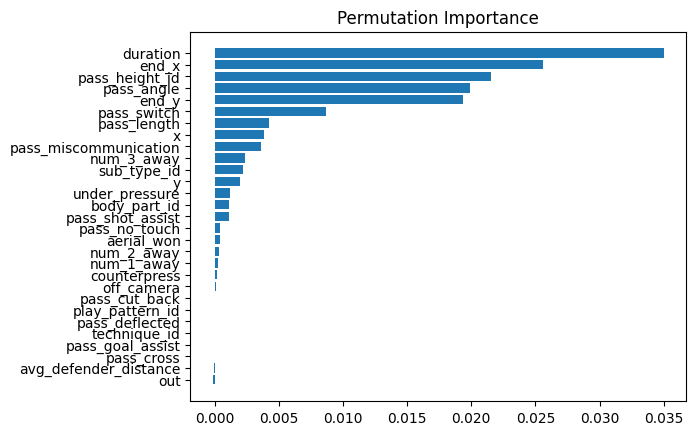

In [15]:
from sklearn.inspection import permutation_importance
start_time = time.time()
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
print(f"Permutation Importances completed in: {(time.time() - start_time):.3f}s")

rf_perm_importances = pd.Series(result.importances_mean, index=all_features).sort_values(ascending=False)
# print("#####################\nPermutation Importances", rf_perm_importances, "\n#####################\n")
# fig, ax = plt.subplots()
# rf_perm_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Permutation Importance")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

scores = rf_perm_importances.sort_values()
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.yticks(width, ticks)
ax.set_ylabel("Mean accuracy decrease")
plt.title("Permutation Importance")
plt.show()

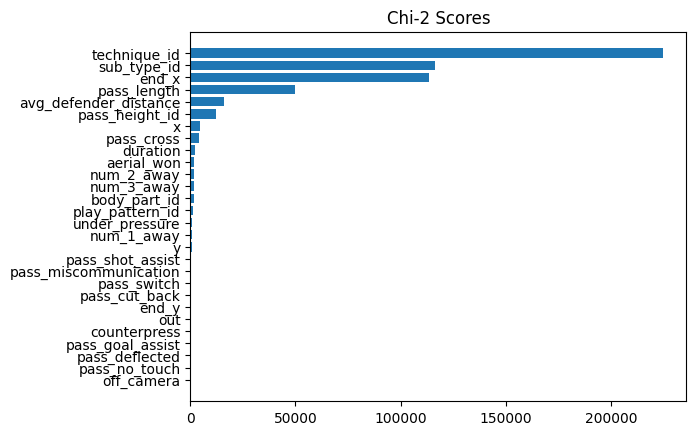

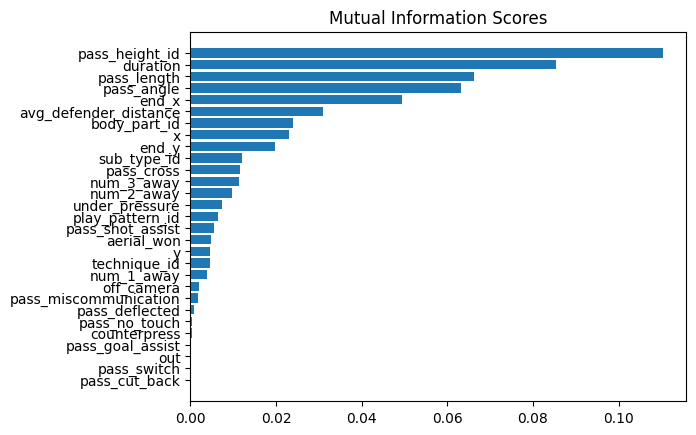

In [16]:
# mutual_info_classif, chi2
X_kchi = SelectKBest(chi2, k='all').fit(X_all.loc[:, X_all.columns!= 'pass_angle'], y)
X_kmut = SelectKBest(mutual_info_classif, k='all').fit(X_all, y)

chi_scores = pd.Series(X_kchi.scores_, index=X_all.columns[X_all.columns != 'pass_angle']).sort_values(ascending=False)
chi_pvalues = pd.Series(X_kchi.pvalues_, index=X_all.columns[X_all.columns != 'pass_angle']).sort_values(ascending=False)
minfo_scores = pd.Series(X_kmut.scores_, index=X_all.columns).sort_values(ascending=False)

scores = chi_scores.sort_values()
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.title("Chi-2 Scores")
plt.show()

scores = minfo_scores.sort_values()
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.show()

In [17]:
print("In Minfo and not in Chi2: ", set(minfo_scores[minfo_scores > 0].index).difference(chi_pvalues[chi_pvalues < 0.005].index))
print("In Chi2 and not in Minfo: ", set(chi_pvalues[chi_pvalues < 0.005].index).difference(minfo_scores[minfo_scores > 0].index))
print("In Imp but not in Minfo: ", set(imp_features).difference(minfo_scores[minfo_scores > 0].index))
print("In MInfo but not in Imp: ", set(minfo_scores[minfo_scores > 0].index).difference(imp_features))
print("In All but not in Minfo: ", set(all_features).difference(minfo_scores[minfo_scores > 0].index))
print("In MInfo but not in All: ", set(minfo_scores[minfo_scores > 0].index).difference(all_features))

In Minfo and not in Chi2:  {'off_camera', 'pass_angle', 'pass_no_touch'}
In Chi2 and not in Minfo:  {'out', 'pass_cut_back', 'pass_goal_assist', 'pass_switch'}
In Imp but not in Minfo:  set()
In MInfo but not in Imp:  {'off_camera', 'num_3_away', 'num_2_away', 'pass_deflected', 'play_pattern_id', 'counterpress', 'pass_no_touch', 'under_pressure', 'pass_cross', 'pass_miscommunication', 'pass_shot_assist', 'technique_id'}
In All but not in Minfo:  {'out', 'pass_cut_back', 'pass_goal_assist', 'pass_switch'}
In MInfo but not in All:  set()


In [18]:
# Excluding all but "under_pressure" due to huge imbalance in value_counts
print(X_all["pass_no_touch"].value_counts(normalize=True), "\n")
print(X_all["pass_miscommunication"].value_counts(normalize=True), "\n")
print(X_all["counterpress"].value_counts(normalize=True), "\n")
print(X_all["out"].value_counts(normalize=True), "\n")
print(X_all["off_camera"].value_counts(normalize=True), "\n")
print(X_all["under_pressure"].value_counts(normalize=True), "\n")
print(X_all["pass_shot_assist"].value_counts(normalize=True), "\n")

pass_no_touch
0    0.999015
1    0.000985
Name: proportion, dtype: float64 

pass_miscommunication
0    0.999488
1    0.000512
Name: proportion, dtype: float64 

counterpress
0.0    0.996534
1.0    0.003466
Name: proportion, dtype: float64 

out
0.0    0.999656
1.0    0.000344
Name: proportion, dtype: float64 

off_camera
0.0    0.998717
1.0    0.001283
Name: proportion, dtype: float64 

under_pressure
0    0.832394
1    0.167606
Name: proportion, dtype: float64 

pass_shot_assist
0    0.983607
1    0.016393
Name: proportion, dtype: float64 



In [19]:
from sklearn.decomposition import PCA
pca = PCA()
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)
pca.fit(X_all)
pca_var = pd.Series(pca.explained_variance_ratio_, index=all_features).sort_values(ascending=False)
pca_sing = pd.Series(pca.singular_values_, index=all_features).sort_values(ascending=False)
print(pca_sing)

duration                 617.895358
pass_length              585.928287
pass_angle               528.212880
pass_height_id           486.529975
end_x                    460.943717
end_y                    388.509738
body_part_id             379.532358
sub_type_id              374.185332
x                        367.452956
y                        363.800989
under_pressure           363.607254
technique_id             362.303352
off_camera               361.383971
counterpress             359.949412
out                      356.764123
num_1_away               352.981397
num_2_away               346.066183
num_3_away               338.948183
avg_defender_distance    325.837098
aerial_won               314.307292
pass_cross               302.323020
pass_switch              294.034626
pass_shot_assist         260.522124
pass_goal_assist         235.040774
pass_cut_back            197.317969
pass_deflected           192.726943
pass_no_touch            152.810802
pass_miscommunication    123

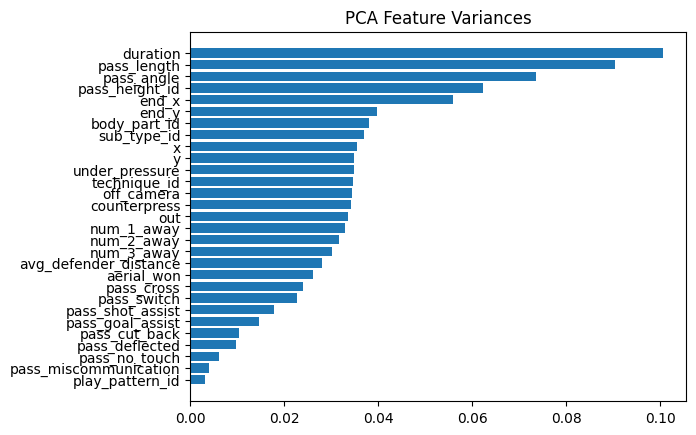

In [20]:
scores = pca_var.sort_values()
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.title("PCA Feature Variances")
plt.show()

### Model Selection

#### DT Selection

In [22]:
# Decision Trees
f = open("DT_params.txt", "w")
for type_, X in X_dict.items():
    # Split the data to train, validation and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 123, stratify = y)
    
    param_grid = {
        'criterion': ['gini', 'entropy', "log_loss"],
        'max_depth': list(np.arange(3, 8)) + [None]
    }
    
    start_time = time.time()
    tree_model = tree.DecisionTreeClassifier(random_state=1234)
    tree_gs_cv = GridSearchCV(tree_model, param_grid, scoring='balanced_accuracy', 
                              cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True))
    tree_gs_cv.fit(X_train, y_train)
    
    duration_ = time.time() - start_time

    # Get accuracies
    train_acc = accuracy_score(tree_gs_cv.predict(X_train), y_train)
    test_acc = accuracy_score(tree_gs_cv.predict(X_test), y_test)
    # Print Time and Params
    print(f"DT Training completing in: {duration_:.3f}s") 
    print(f"Best Params, Score: {tree_gs_cv.best_params_, tree_gs_cv.best_score_}")
    
    # Show Training and Testing Accuracy
    print(f"Training Accuracy: {train_acc}") 
    print(f"Testing Accuracy: {test_acc}")
    print("##################\n")
    
    f.write(f"\nModel {type_}\nTraining completing in: {duration_:.3f}s\nBest Params: {tree_gs_cv.best_params_}\nBest Score: {tree_gs_cv.best_score_}\
            \nTraining Accuracy: {train_acc}\nTesting Accuracy: {test_acc}\n")
f.close()

DT Training completing in: 99.410s
Best Params, Score: ({'criterion': 'gini', 'max_depth': 5}, 0.7618943977073764)
Training Accuracy: 0.8518231694680468
Testing Accuracy: 0.8497442292520296
##################

DT Training completing in: 114.856s
Best Params, Score: ({'criterion': 'gini', 'max_depth': 6}, 0.7827146987173829)
Training Accuracy: 0.8630795911911956
Testing Accuracy: 0.859033415621103
##################

DT Training completing in: 123.920s
Best Params, Score: ({'criterion': 'gini', 'max_depth': 5}, 0.7945406497087782)
Training Accuracy: 0.8592729136898594
Testing Accuracy: 0.8576336752093248
##################



#### XGB Selection

In [23]:
# XGB
f = open("XGB_params.txt", "w")
for type_, X  in X_dict.items():
    #split the data to train, validation and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 123, stratify = y)
    
    param_grid = {
        "learning_rate": [0.001],
        "n_estimators": [2000],
        "max_depth": [8],
    }
    
    start_time = time.time()
    xgb_tree_model = XGBClassifier(random_state=1234)
    xgb_tree_gs_cv = RandomizedSearchCV(
        xgb_tree_model, param_distributions=param_grid, scoring='balanced_accuracy',
        cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True), verbose=2)
    xgb_tree_gs_cv.fit(X_train, y_train)

    duration_ = time.time() - start_time

    # Get accuracies
    train_acc = accuracy_score(xgb_tree_gs_cv.predict(X_train), y_train)
    test_acc = accuracy_score(xgb_tree_gs_cv.predict(X_test), y_test)
    # Print Time and Params
    print(f"XGB Training completing in: {duration_:.3f}s") 
    print(f"Best Params, Score: {xgb_tree_gs_cv.best_params_, xgb_tree_gs_cv.best_score_}")
    
    # Show Training and Testing Accuracy
    print(f"Training Accuracy: {train_acc}") 
    print(f"Testing Accuracy: {test_acc}")
    print("##################\n")
    
    f.write(f"\nModel {type_}\nTraining completing in: {duration_:.3f}s\nBest Params: {xgb_tree_gs_cv.best_params_}\nBest Score: {xgb_tree_gs_cv.best_score_}\
            \nTraining Accuracy: {train_acc}\nTesting Accuracy: {test_acc}\n")
f.close()

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END learning_rate=0.001, max_depth=8, n_estimators=2000; total time=  11.7s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=2000; total time=  12.0s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=2000; total time=  11.7s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=2000; total time=  11.9s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=2000; total time=  11.6s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=2000; total time=  11.6s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=2000; total time=  11.4s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=2000; total time=  12.3s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=2000; total time=  11.4s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=2000; total time=  11.5s
XGB Training completing in: 130.059s
Best Params, Score: ({'n_estimators': 2000, 'max_depth': 8, 'learning_rate': 0.001}, 0.76539

#### NN Selection

In [26]:
# neg, pos = np.bincount(np.where(clean_pass_df["outcome_id"].isnull(), 1, 0))
# total = neg + pos
# print('Total: {}\nPositive: {} ({:.2f}% of total)\n'.format(
#     total, pos, 100 * pos / total))

Total: 130974
Positive: 105004 (80.17% of total)



In [27]:
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# def plot_loss(history, label, n):
#     # Use a log scale on y-axis to show the wide range of values.
#     plt.semilogy(history.epoch, history.history['loss'],
#                color=colors[n], label='Train ' + label)
#     plt.semilogy(history.epoch, history.history['val_loss'],
#                color=colors[n], label='Val ' + label,
#                linestyle="--")
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

In [28]:
# METRICS = [
#       keras.metrics.BinaryCrossentropy(name='cross entropy'),
#       keras.metrics.MeanSquaredError(name='Brier score'),
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'),
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
#       keras.metrics.AUC(name='prc', curve='PR'),
# ]

# def create_nn_model(input_dim, hidden_layers, neurons_per_layer, dropout_rate=0.2, output_bias=None):
#     if output_bias is not None:
#         output_bias = tf.keras.initializers.Constant(output_bias)
#     model = Sequential()
#     model.add(Dense(neurons_per_layer[0], activation='relu', input_dim=input_dim))
#     model.add(BatchNormalization())
    
#     for i in range(1, hidden_layers):
#         model.add(Dense(neurons_per_layer[i], activation='relu'))
#         model.add(BatchNormalization())
        
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))

#     model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
#     return model

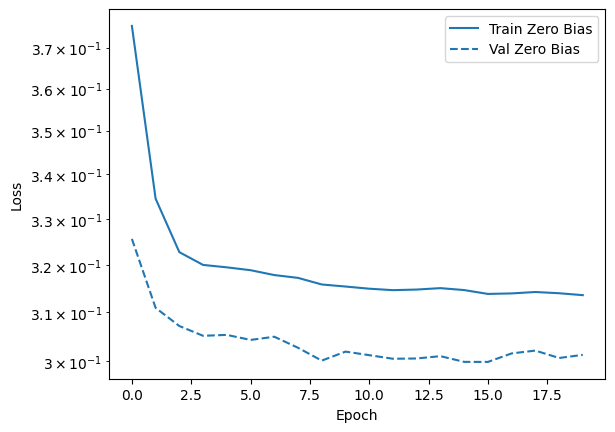

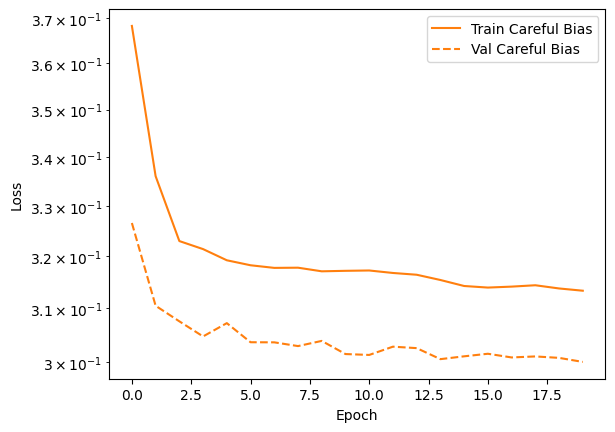

In [30]:
# # Split data
# X_train, X_val, y_train, y_val = train_test_split(X_basic, y, train_size = 0.7, random_state = 123, stratify = y)

# # Scale data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

# model1 = create_nn_model(X_train.shape[1], 1, [32], output_bias=0.0)
# zero_bias_history = model1.fit(
#     X_train,
#     y_train,
#     batch_size=32,
#     epochs=20,
#     validation_data=(X_val, y_val),
#     verbose=0)

# model2 = create_nn_model(X_train.shape[1], 1, [32], output_bias=np.log([pos/neg]))
# careful_bias_history = model2.fit(
#     X_train,
#     y_train,
#     batch_size=32,
#     epochs=20,
#     validation_data=(X_val, y_val),
#     verbose=0)
# plot_loss(zero_bias_history, "Zero Bias", 0)
# plot_loss(careful_bias_history, "Careful Bias", 1)

In [228]:
# def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_cal, y_cal, epochs=100, batch_size=32):
#     start_time = time.time()
#     early_stopping = EarlyStopping(monitor='val_prc', patience=10, restore_best_weights=True)

#     history = model.fit(
#         X_train, y_train,
#         validation_data=(X_val, y_val),
#         epochs=epochs,
#         batch_size=batch_size,
#         callbacks=[early_stopping],
#         verbose=0
#     )

#     # plot_loss(history, "History", 1)

#     # Metrics
#     y_pred = (model.predict(X_cal) > 0.5).astype(int)
#     accuracy = accuracy_score(y_cal, y_pred)
#     precision = precision_score(y_cal, y_pred)
#     recall = recall_score(y_cal, y_pred)
#     f1 = f1_score(y_cal, y_pred)
#     brier_score = brier_score_loss(y_cal, y_pred)
#     time_ = round(time.time() - start_time, 4)
#     print(f"Training completed in: {time_}s")

#     y_pred = model.predict(X_cal)

#     fig, axs = plt.subplots()
#     #ROC CURVE
#     fpr, tpr, _ = roc_curve(y_cal,  y_pred)
#     auc = roc_auc_score(y_cal, y_pred)
#     axs.plot(fpr,tpr,label= "AUC = " + str(auc)[:4])
#     axs.plot([0, 1], [0, 1], color='black', ls = '--')
#     axs.legend()
#     axs.set_ylabel('True Positive Rate')
#     axs.set_xlabel('False Positive Rate')
#     axs.set_title('ROC curve')
    
#     return accuracy, precision, recall, f1, brier_score, time_, history

In [220]:
# def model_selection(X, y):
#     # Split data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state = 123, stratify = y)
#     X_cal, X_val, y_cal, y_val  = train_test_split(X_test, y_test, train_size = 0.5, random_state = 123, stratify = y_test)

#     # Scale data
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_val = scaler.transform(X_val)
#     X_cal = scaler.transform(X_cal)
    
#     # Architectures to test
#     architectures = [
#         # (1, [64]),
#         # (1, [32]),
#         # (2, [64, 32]),
#         # (2, [64, 16]),
#         (2, [32, 16])
#         # ,
#         # (2, [32, 8]),
#         # (3, [128, 64, 32]),
#         # (3, [64, 32, 16]),
#         # (3, [32, 16, 8]),
#         # (4, [128, 64, 32, 16])
#     ]
    
#     results = []
    
#     for hidden_layers, neurons_per_layer in architectures:
#         model = create_nn_model(X_train.shape[1], hidden_layers, neurons_per_layer)

#         print(f"\n###################\t({neurons_per_layer})\t###################")
#         accuracy, precision, recall, f1, brier_score, time_, history = train_and_evaluate_model(
#             model, X_train, y_train, X_val, y_val, X_cal, y_cal
#         )
        
#         results.append({
#             'Hidden Layers': hidden_layers,
#             'Neurons per Layer': neurons_per_layer,
#             'Accuracy': accuracy,
#             'Precision': precision,
#             'Recall': recall,
#             'F1 Score': f1,
#             'Brier Score': brier_score,
#             'Time': time_
#         })
    
#     # Return results
#     results_df = pd.DataFrame(results)
#     return results_df


###################	([64])	###################


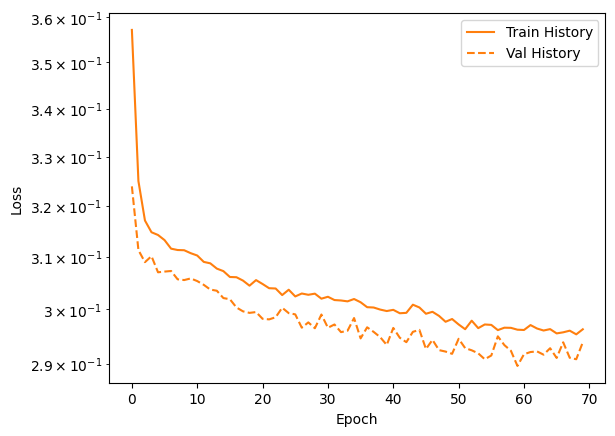

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
Training completed in: 141.8061s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step

###################	([32])	###################


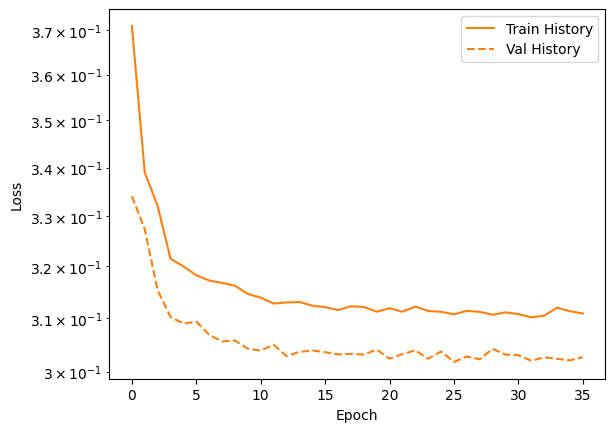

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
Training completed in: 71.399s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step

###################	([64, 32])	###################


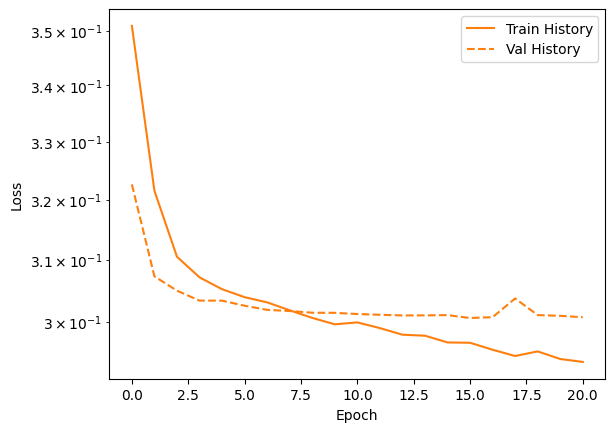

819/819 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step
Training completed in: 49.8187s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step

###################	([64, 16])	###################


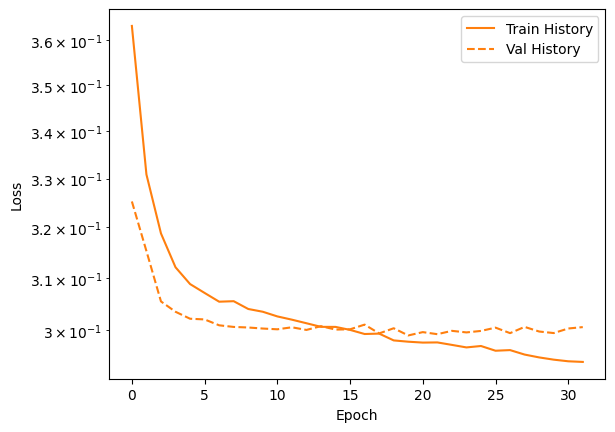

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
Training completed in: 335.4212s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step

###################	([32, 16])	###################


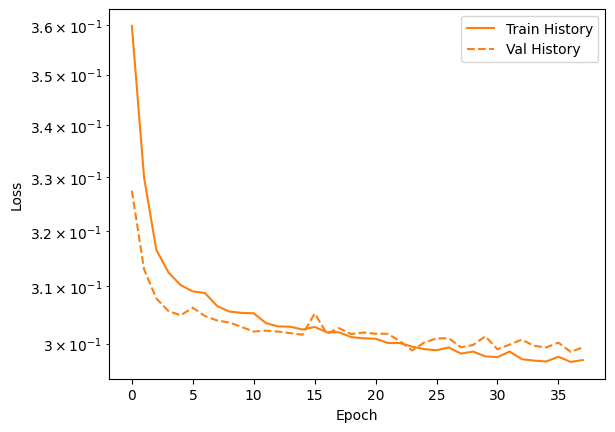

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
Training completed in: 87.2158s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step

###################	([32, 8])	###################


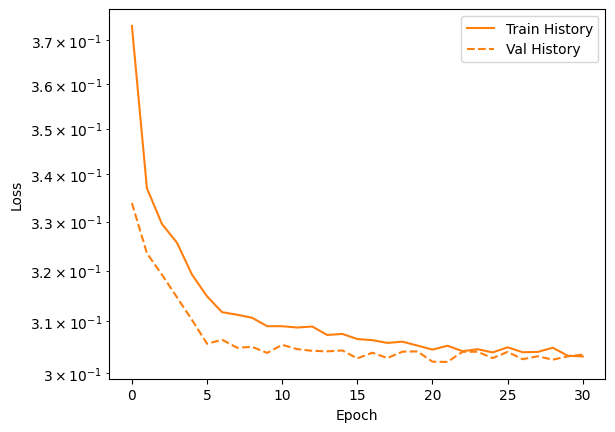

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
Training completed in: 70.3218s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step

###################	([128, 64, 32])	###################


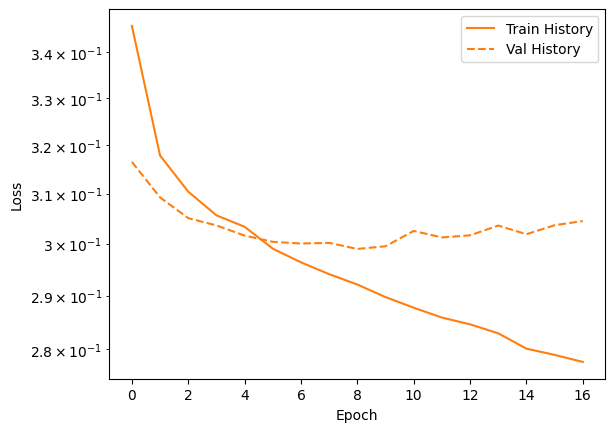

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
Training completed in: 49.2833s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step

###################	([64, 32, 16])	###################


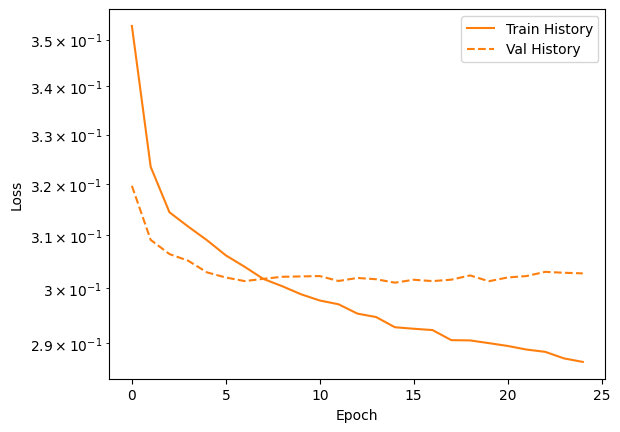

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
Training completed in: 64.6401s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step

###################	([32, 16, 8])	###################


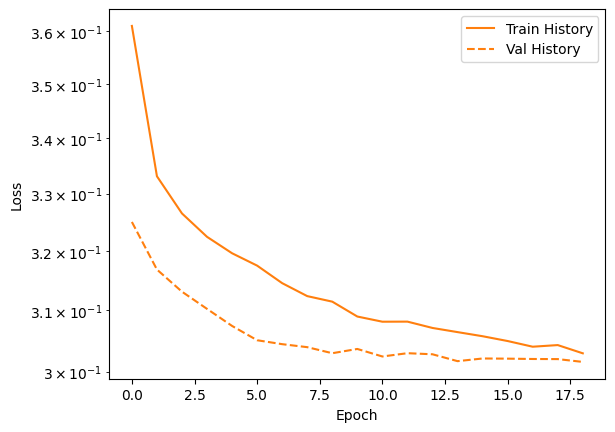

819/819 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step
Training completed in: 48.9802s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step

###################	([128, 64, 32, 16])	###################


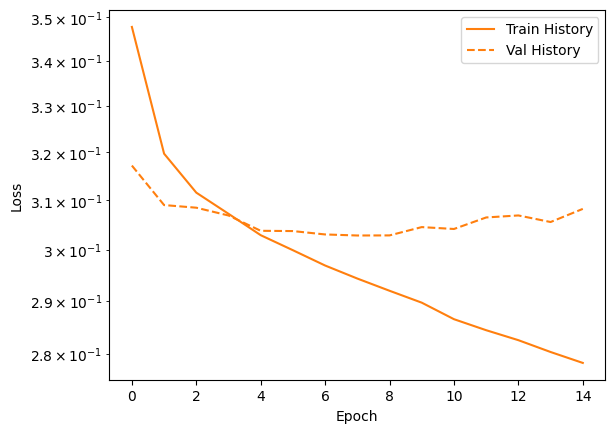

819/819 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step
Training completed in: 46.992s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
 Hidden Layers Neurons per Layer  Accuracy  Precision   Recall  F1 Score  Brier Score     Time
             1              [64]  0.874594   0.910131 0.936003  0.922886     0.125406 141.8061
             1              [32]  0.869822   0.907936 0.932146  0.919882     0.130178  71.3990
             2          [64, 32]  0.870510   0.911022 0.929241  0.920041     0.129490  49.8187
             2          [64, 16]  0.870204   0.909078 0.931241  0.920026     0.129796 335.4212
             2          [32, 16]  0.869822   0.909341 0.930384  0.919742     0.130178  87.2158
             2           [32, 8]  0.869364   0.910859 0.927861  0.919281     0.130636  70.3218
             3     [128, 64, 32]  0.870510   0.912138 0.927861  0.919932     0.129490  49.2833
             3      [64, 32, 16]  0.870739   0.910243 0.930527  0.920273     0.129261  64.6401
             3       [32, 16

In [33]:
# basic_models_results_df = model_selection(X_basic, y)
# print(basic_models_results_df.to_string(index=False))
# # Find the best model
# best_model = basic_models_results_df.loc[basic_models_results_df['F1 Score'].idxmax()]
# print("\nBest Model:")
# print(best_model.to_string())


###################	([64])	###################


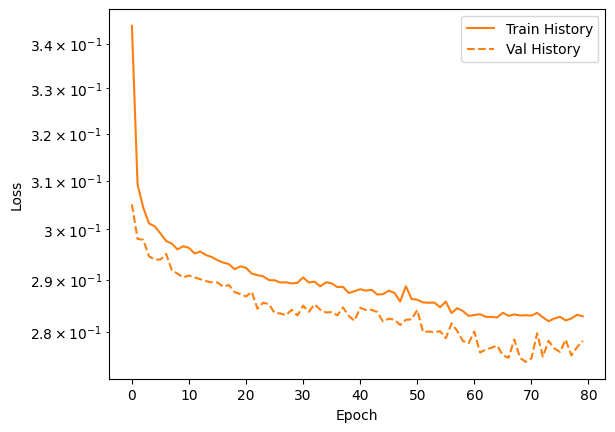

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
Training completed in: 180.4948s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step

###################	([32])	###################


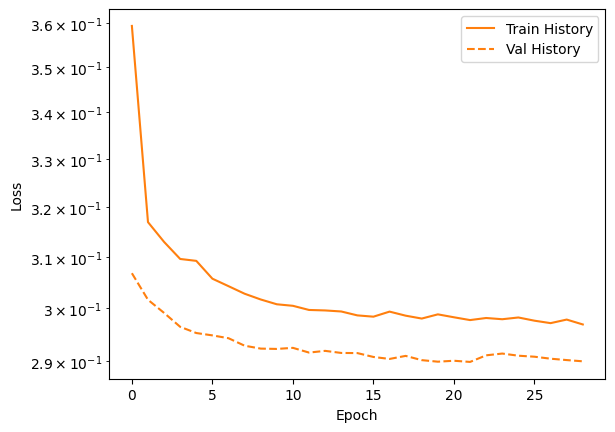

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
Training completed in: 59.557s
819/819 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step

###################	([64, 32])	###################


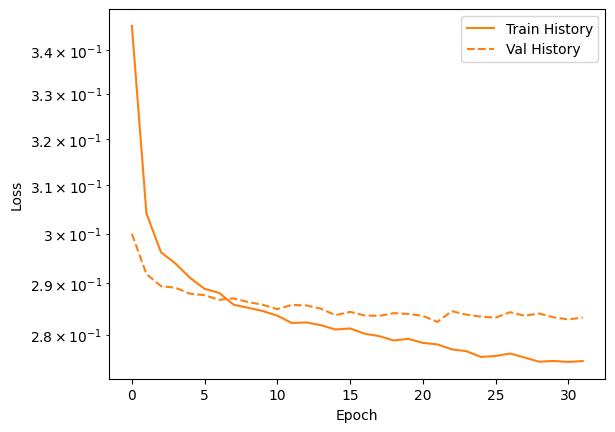

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
Training completed in: 95.2356s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step

###################	([64, 16])	###################


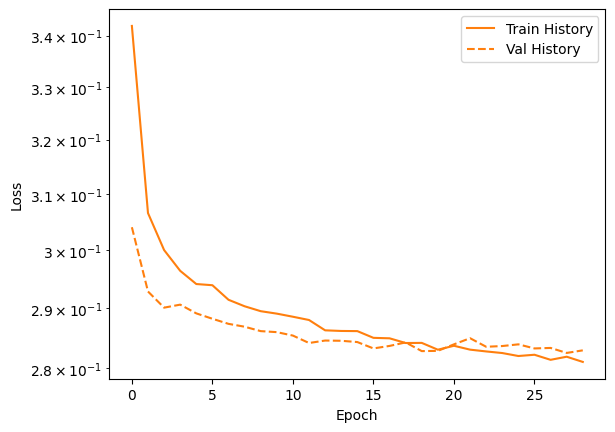

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
Training completed in: 69.8934s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step

###################	([32, 16])	###################


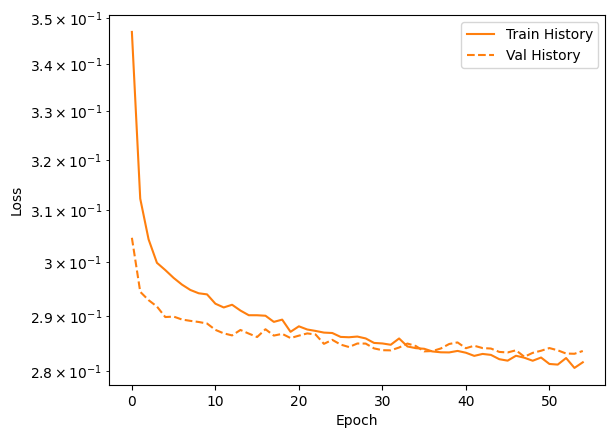

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
Training completed in: 131.2531s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step

###################	([32, 8])	###################


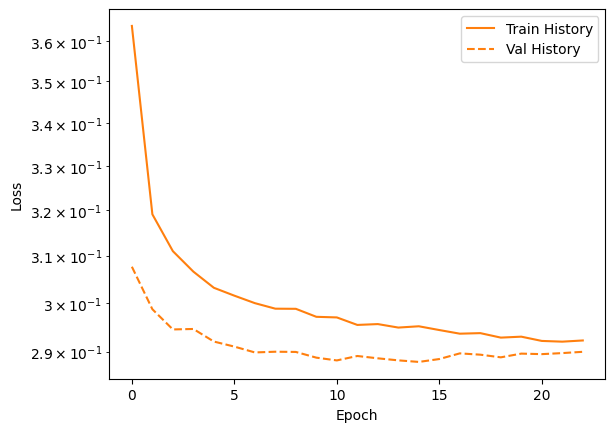

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
Training completed in: 55.303s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step

###################	([128, 64, 32])	###################


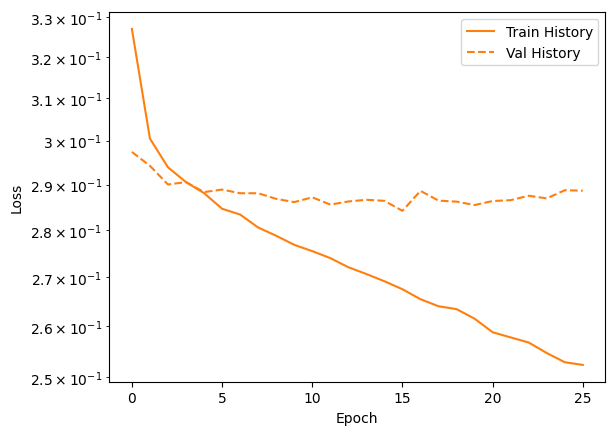

819/819 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training completed in: 78.0594s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step

###################	([64, 32, 16])	###################


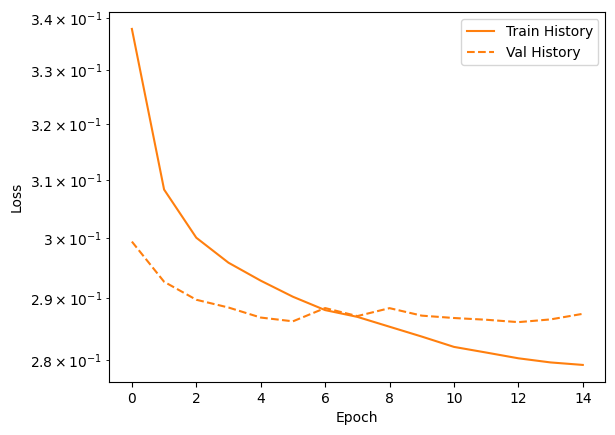

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
Training completed in: 44.084s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step

###################	([32, 16, 8])	###################


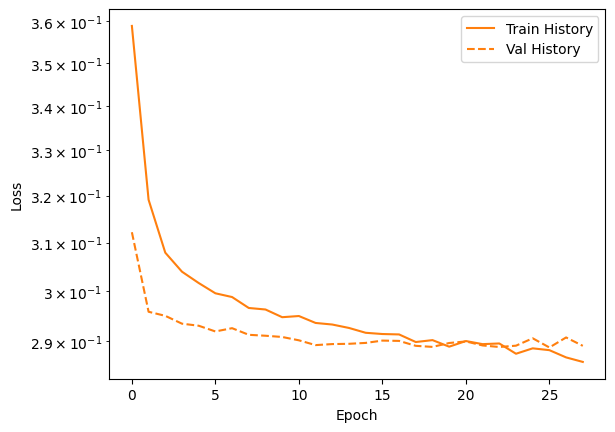

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
Training completed in: 71.4528s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step

###################	([128, 64, 32, 16])	###################


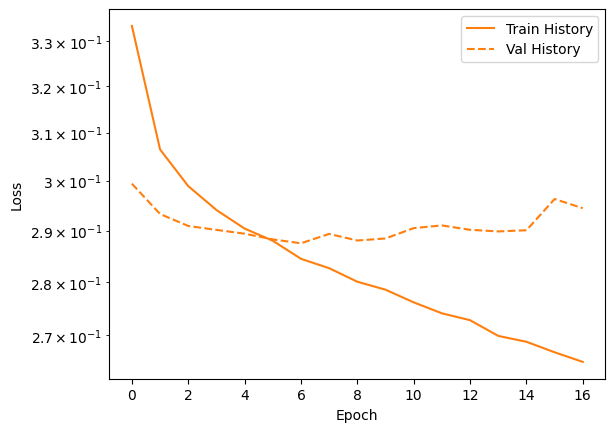

819/819 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step
Training completed in: 59.3132s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
 Hidden Layers Neurons per Layer  Accuracy  Precision   Recall  F1 Score  Brier Score     Time
             1              [64]  0.881619   0.914160 0.940669  0.927225     0.118381 180.4948
             1              [32]  0.875320   0.911084 0.935813  0.923283     0.124680  59.5570
             2          [64, 32]  0.878450   0.912870 0.937908  0.925220     0.121550  95.2356
             2          [64, 16]  0.878221   0.914769 0.935241  0.924892     0.121779  69.8934
             2          [32, 16]  0.877877   0.913270 0.936622  0.924798     0.122123 131.2531
             2           [32, 8]  0.875205   0.908421 0.939003  0.923459     0.124795  55.3030
             3     [128, 64, 32]  0.876999   0.910544 0.938812  0.924462     0.123001  78.0594
             3      [64, 32, 16]  0.877343   0.910316 0.939574  0.924714     0.122657  44.0840
             3       [32, 1

In [34]:
# imp_models_results_df = model_selection(X_imp, y)
# print(imp_models_results_df.to_string(index=False))
# # Find the best model
# best_model = imp_models_results_df.loc[imp_models_results_df['F1 Score'].idxmax()]
# print("\nBest Model:")
# print(best_model.to_string())


###################	([32, 16])	###################
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
Training completed in: 95.1631s
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
 Hidden Layers Neurons per Layer  Accuracy  Precision   Recall  F1 Score  Brier Score    Time
             2          [32, 16]  0.886505   0.914666 0.946764  0.930438     0.113495 95.1631

Best Model:
Hidden Layers               2
Neurons per Layer    [32, 16]
Accuracy             0.886505
Precision            0.914666
Recall               0.946764
F1 Score             0.930438
Brier Score          0.113495
Time                  95.1631


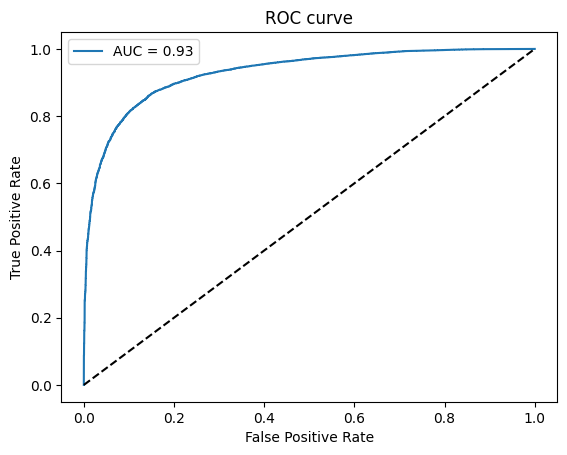

In [229]:
# all_models_results_df = model_selection(X_all, y)
# print(all_models_results_df.to_string(index=False))
# # Find the best model
# best_model = all_models_results_df.loc[all_models_results_df['F1 Score'].idxmax()]
# print("\nBest Model:")
# print(best_model.to_string())

### Testing Best Models

In [24]:
## MAIN TESTING DRIVER
test_pass_df, test_event_df, test_related_df, test_frames_df = gather_data(test_ids)

# Only store those rows that have corresponding 360 entry in frames_df
test_clean_pass_df = clean_passes(test_pass_df, test_frames_df)

test_new_metrics_df, test_clean_pass_df = create_new_metrics(test_clean_pass_df, test_frames_df)
# Add new metrics to our main_df
test_clean_pass_df = pd.concat([test_clean_pass_df, test_new_metrics_df], axis=1)

Matches : 51


/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/sparshbinjrajka/Downloads/Football Papers + Models/ftblenv/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not

Data Gathering completed in: 120.5s
Player_within_distances completed in 7.87s


/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/4125588332.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  opposition_positions = frames_df[frames_df['teammate'] == False].groupby('event_uuid').apply(lambda g: g[['x', 'y']].values).to_dict()
/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/2822652700.py:17: RuntimeWarning: invalid value encountered in divide
  distances = np.abs(A * points[..., 0] + B * points[..., 1] + C) / np.sqrt(A**2 + B**2)


Closest_defender_passing_line completed in 26.41s


In [25]:
# Aggregate old data
complete_pass_df = pd.concat([clean_pass_df, test_clean_pass_df], axis=0)
complete_event_df = pd.concat([event_df, test_event_df], axis=0)
complete_related_df = pd.concat([related_df, test_related_df], axis=0)
complete_frames_df = pd.concat([frames_df, test_frames_df], axis=0)

In [26]:
#store dependent variable 
y_complete_true = complete_pass_df["outcome_id"].to_frame()
y_complete_true = standardise_target(y_complete_true)

#store independent variables
X_complete_basic = complete_pass_df[basic_features + created_features]
X_complete_basic = standardise_features(X_complete_basic)

X_complete_imp = complete_pass_df[imp_features]
X_complete_imp = standardise_features(X_complete_imp)

X_complete_all = complete_pass_df[all_features]
X_complete_all = standardise_features(X_complete_all)

X_complete_dict = {"basic":X_complete_basic, "imp":X_complete_imp, "all":X_complete_all}

/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/2834275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_under_pressure"] = np.where(df["under_pressure"].isnull(), 0, 1)
/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/2834275.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["under_pressure"], axis=1, inplace=True)
/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/2834275.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

no under pressure


/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/2834275.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/2834275.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[object_columns] = df[object_columns].astype(int)


### Best Models Retrained

In [27]:
# Best Models Retrained

# Split data into train and test

# # Basic
# X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(X_complete_basic, y_complete_true, train_size = 0.7, random_state = 123, stratify = y_complete_true)
# scaler_basic = StandardScaler()
# X_train_basic = scaler_basic.fit_transform(X_train_basic)
# X_test_basic = scaler_basic.transform(X_test_basic)

# # Imp
# X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_complete_imp, y_complete_true, train_size = 0.7, random_state = 123, stratify = y_complete_true)
# scaler_imp = StandardScaler()
# X_train_imp = scaler_imp.fit_transform(X_train_imp)
# X_test_imp = scaler_imp.transform(X_test_imp)

# All
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_complete_all, y_complete_true, train_size = 0.7, random_state = 123, stratify = y_complete_true)
scaler_all = StandardScaler()
X_train_all = scaler_all.fit_transform(X_train_all)
X_test_all = scaler_all.transform(X_test_all)

# ## DT
# print("###############\t DT MODELS\t###############")

# # Basic
# start_time = time.time()
# model_dt_basic = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1234)
# history_dt_basic = model_dt_basic.fit(X_train_basic, y_train_basic)
# print(f"Basic trained in: {time.time() - start_time}s")

# # Imp
# start_time = time.time()
# model_dt_imp = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1234)
# history_dt_imp = model_dt_imp.fit(X_train_imp, y_train_imp)
# print(f"Imp trained in: {time.time() - start_time}s")

# # All
# start_time = time.time()
# model_dt_all = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1234)
# history_dt_all = model_dt_all.fit(X_train_all, y_train_all)
# print(f"All trained in: {time.time() - start_time}s")


## XGB
print("###############\t XGB MODELS\t###############")

# # Basic
# start_time = time.time()
# model_xgb_basic = XGBClassifier(n_estimators=2000, max_depth=7, learning_rate=0.01, eval_metric="logloss", random_state=1234, use_label_encoder=False)
# history_xgb_basic = model_xgb_basic.fit(X_train_basic, y_train_basic)
# print(f"Basic trained in: {time.time() - start_time}s")

# Imp
# start_time = time.time()
# model_xgb_imp = XGBClassifier(n_estimators=2000, max_depth=7, learning_rate=0.01, eval_metric="logloss", random_state=1234, use_label_encoder=False)
# history_xgb_imp = model_xgb_imp.fit(X_train_imp, y_train_imp)
# print(f"Imp trained in: {time.time() - start_time}s")

# All
start_time = time.time()
model_xgb_all = XGBClassifier(n_estimators=2000, max_depth=8, learning_rate=0.001, eval_metric="logloss", random_state=1234, use_label_encoder=False)
history_xgb_all = model_xgb_all.fit(X_train_all, y_train_all)
print(f"All trained in: {time.time() - start_time}s")


# ## NN Models
# print("###############\t NN MODELS\t###############")

# # Basic
# start_time = time.time()
# model_nn_basic = create_nn_model(X_train_basic.shape[1], 1, [64])
# history_nn_basic = model_nn_basic.fit(X_train_basic, y_train_basic, epochs=100, batch_size=32, verbose=0)
# print(f"Basic trained in: {time.time() - start_time}s")
# plt.semilogy(history_nn_basic.epoch, history_nn_basic.history['loss'], color=colors[1], label='Train NN Basic')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Imp
# start_time = time.time()
# model_nn_imp = create_nn_model(X_train_imp.shape[1], 1, [64])
# history_nn_imp = model_nn_imp.fit(X_train_imp, y_train_imp, epochs=100, batch_size=32, verbose=0)
# print(f"Imp trained in: {time.time() - start_time}s")
# plt.semilogy(history_nn_imp.epoch, history_nn_imp.history['loss'], color=colors[0], label='Train NN Imp')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


# # All
# start_time = time.time()
# model_nn_all = create_nn_model(X_train_all.shape[1], 3, [64, 32, 16])
# history_nn_all = model_nn_all.fit(X_train_all, y_train_all, epochs=100, batch_size=32, verbose=0)
# print(f"All trained in: {time.time() - start_time}s")
# plt.semilogy(history_nn_all.epoch, history_nn_all.history['loss'], color=colors[1], label='Train NN All')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

###############	 XGB MODELS	###############
All trained in: 16.590993881225586s


In [130]:
# # Get testing results
# best_models = [model_dt_basic, model_dt_imp, model_dt_all, 
#                model_xgb_basic, model_xgb_imp, model_xgb_all, 
#                model_nn_basic, model_nn_imp, model_nn_all]
# data_vars = [(X_test_basic,y_test_basic), (X_test_imp,y_test_imp), (X_test_all,y_test_all)]
# accuracies = []
# predicted_probs = []

# model_types = ["DT", "XGB", "NN"]
# data_types = ["Basic", "Imp", "All"]

# for i in range(len(model_types)):
#     for j in range(len(data_types)):
#         X_test_, y_test_ = data_vars[j]
#         if i < 2:
#             prob = best_models[3*i + j].predict_proba(X_test_)[:, 1]
#         else:
#             prob = best_models[3*i + j].predict(X_test_).ravel()
#         pred = np.where(prob > 0.8, 1, 0)
#         accuracies.append(balanced_accuracy_score(y_test_, pred))
#         predicted_probs.append(prob)

# print("############\tAccuracy\t#############")
# for i in range(len(model_types)):
#     for j in range(len(data_types)):
#         print(f"Model:\t{model_types[i]}\t{data_types[j]}\tAccuracy: {accuracies[3*i + j]}")

1660/1660 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 1s 359us/step
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step
############	Accuracy	#############
Model:	DT	Basic	Accuracy: 0.8185370868176206
Model:	DT	Imp	Accuracy: 0.8225653786443822
Model:	DT	All	Accuracy: 0.8272811546893237
Model:	XGB	Basic	Accuracy: 0.8533828548206761
Model:	XGB	Imp	Accuracy: 0.8596550234422761
Model:	XGB	All	Accuracy: 0.8714383279039448
Model:	NN	Basic	Accuracy: 0.8472900173424837
Model:	NN	Imp	Accuracy: 0.8558249789758112
Model:	NN	All	Accuracy: 0.8516975133581739


In [31]:
print("Model XGB trained on ALL Features")
predicted_prob = model_xgb_all.predict_proba(X_test_all)[:, 1]
print(f"Accuracy: {balanced_accuracy_score(y_test_all, np.where(predicted_prob > 0.8, 1, 0))}")

Model XGB trained on ALL Features
Accuracy: 0.8589721971910076


In [86]:
 model_xgb_all.predict_proba(X_complete_all.head(10))[:,1]

array([0.7310351 , 0.3621132 , 0.18920983, 0.39850467, 0.35428706,
       0.3621132 , 0.4974098 , 0.3621132 , 0.35826632, 0.49003148],
      dtype=float32)

In [89]:
X_complete_all.head(10)

,duration,pass_length,pass_angle,pass_height_id,end_x,end_y,body_part_id,sub_type_id,x,y,technique_id,off_camera,counterpress,out,num_1_away,num_2_away,num_3_away,avg_defender_distance,aerial_won,pass_cross,pass_switch,pass_shot_assist,pass_goal_assist,pass_cut_back,pass_deflected,pass_no_touch,pass_miscommunication,play_pattern_id,under_pressure
0,1.511008,26.681080,-2.883887,1.0,35.2,33.3,40.0,65.0,61.0,40.1,0.0,0.0,0.0,0.0,0,0,0,12.225815,0,0,0,0,0,0,0,0,0,9,0
1,1.463245,21.345960,1.256453,1.0,44.2,54.1,38.0,0.0,37.6,33.8,0.0,0.0,0.0,0.0,0,0,0,31.534775,0,0,0,0,0,0,0,0,0,9,0
2,2.867591,43.871746,-0.465686,3.0,89.6,35.6,40.0,0.0,50.4,55.3,0.0,0.0,0.0,0.0,0,0,1,9.375160,0,0,0,0,0,0,0,0,0,9,1
3,0.957823,13.010765,-0.785398,1.0,89.6,10.4,38.0,0.0,80.4,19.6,0.0,0.0,0.0,0.0,0,0,1,18.131136,0,0,0,0,0,0,0,0,0,9,0
4,2.681273,37.980650,3.044020,1.0,51.8,14.1,38.0,0.0,89.6,10.4,0.0,0.0,0.0,0.0,0,0,0,24.627114,0,0,0,0,0,0,0,0,0,9,0
6,1.034201,16.623478,2.518546,1.0,45.4,18.8,38.0,0.0,58.9,9.1,0.0,0.0,0.0,0.0,0,0,0,29.932825,0,0,0,0,0,0,0,0,0,9,0
7,1.132377,9.404786,-1.602700,1.0,48.4,14.4,40.0,0.0,48.7,23.8,0.0,0.0,0.0,0.0,0,0,0,19.397755,0,0,0,0,0,0,0,0,0,9,0
8,1.532448,16.731407,2.755537,1.0,32.9,20.7,38.0,0.0,48.4,14.4,0.0,0.0,0.0,0.0,0,0,0,22.383647,0,0,0,0,0,0,0,0,0,9,0
9,1.761593,28.653970,1.942230,1.0,34.8,51.9,38.0,0.0,45.2,25.2,0.0,0.0,0.0,0.0,0,0,0,22.986312,0,0,0,0,0,0,0,0,0,9,0
10,1.905469,20.591260,-1.434394,1.0,45.1,30.2,38.0,0.0,42.3,50.6,0.0,0.0,0.0,0.0,0,0,0,22.939576,0,0,0,0,0,0,0,0,0,9,0


In [93]:
y_complete_true

,outcome_id
0,1
1,1
2,0
3,1
4,1
...,...
53884,1
53885,1
53887,1
53888,1


In [94]:
predicted_prob_all = model_xgb_all.predict_proba(X_complete_all)[:, 1]
print(f"Accuracy: {balanced_accuracy_score(y_complete_true, np.where(predicted_prob_all > 0.75, 1, 0))}")

Accuracy: 0.5108053615266428


In [32]:
# df_probs = pd.DataFrame(list(map(list, zip(*predicted_probs))))
# desired_mean = 0.75

# # Calculate current means and scaling factors
# current_means = df_probs.mean()
# scaling_factors = desired_mean / current_means

# # Vectorized scaling operation
# scaled_array = np.where(df_probs.values > current_means.values+0.15,
#                         1 - (1 - df_probs.values) * scaling_factors.values,
#                         df_probs.values * scaling_factors.values)

# # Create a new DataFrame with scaled values
# scaled_df = pd.DataFrame(scaled_array, columns=df_probs.columns, index=df_probs.index)

# # Clip values to ensure they remain between 0 and 1
# final_scaled_df = scaled_df.clip(0, 1)

# new_probs = []
# for column in final_scaled_df.columns:
#     new_probs.append(final_scaled_df[column].tolist())
    
# final_scaled_df.describe()

### xT

In [33]:
xt_df = complete_related_df[['match_id', 'id', 'index', 'type_name']].merge(
    complete_event_df[['match_id', 'id', 'index', 'type_name', 'comp_id', 'seas_id',
                        'possession_team_id', 'end_x', 'end_y', 'x', 'y', 'player_name','outcome_name']], 
    on=['match_id', 'id', 'index', 'type_name'], how='left').sort_values(by=['match_id', 'index'])
xt_df = xt_df[xt_df["type_name"].isin(['Pass', 'Carry', 'Shot'])].reset_index(drop=True).drop_duplicates()

In [34]:
xt_df = complete_event_df.dropna(subset=["end_x", "end_y"])
xt_df = xt_df[xt_df["type_name"] != "Goal Keeper"]
xt_df = clean_passes(xt_df, complete_frames_df)
# xt_df[["x", "y", "end_x", "end_y"]].describe()
# xt_df.columns

#### Take 1

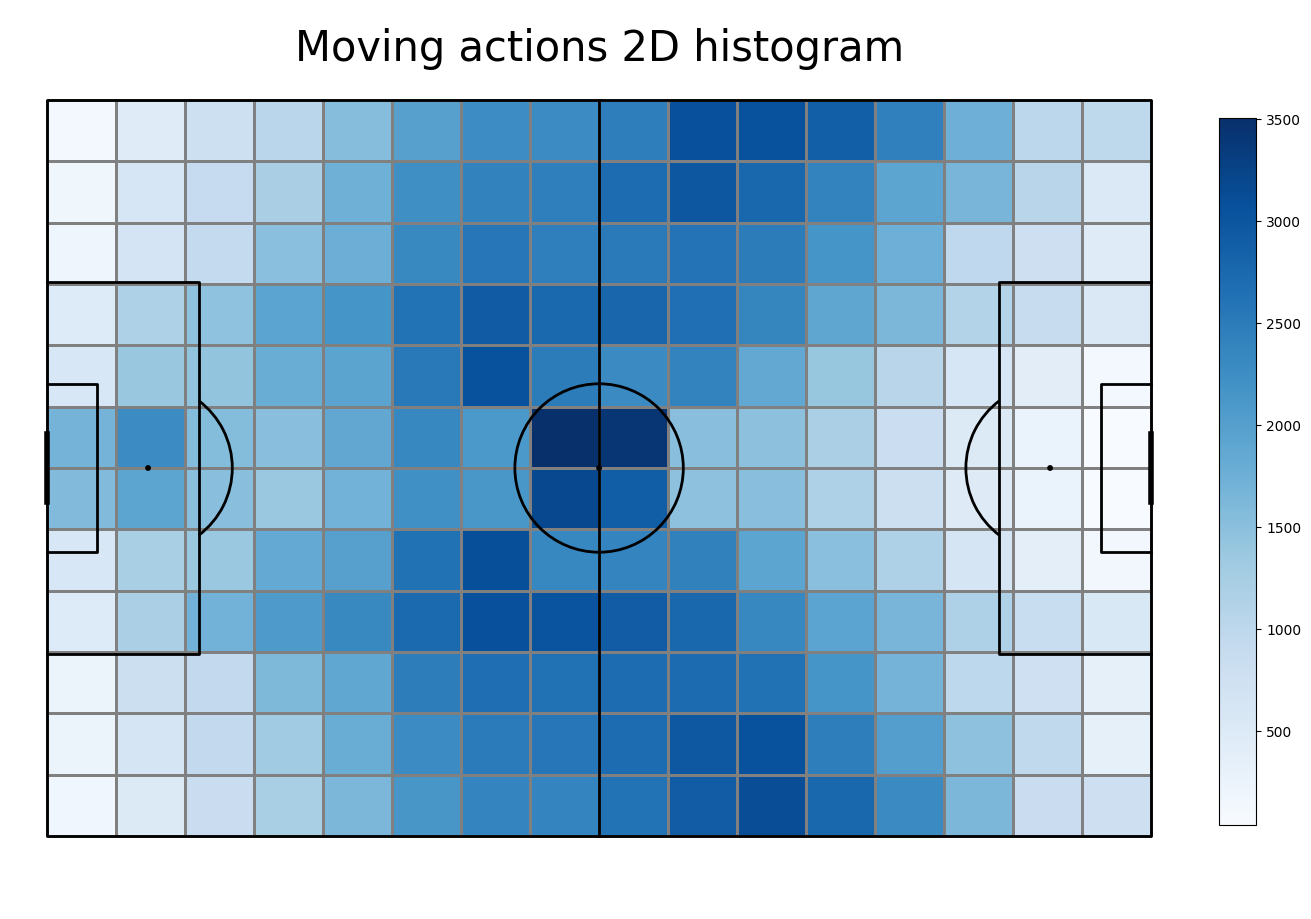

In [35]:
# next_event = df.shift(-1, fill_value=0)
# df["nextEvent"] = next_event["subEventName"]

# df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)
# #get move_df
# move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
# #filtering out of the field
# delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = xt_df[xt_df["type_name"] != "Shot"]
move_df = move_df.loc[(((move_df["end_x"] != 0) & (move_df["end_y"] != 80)) & ((move_df["end_x"] != 120) & (move_df["end_y"] != 0)))]

#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=120, pitch_width=80, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

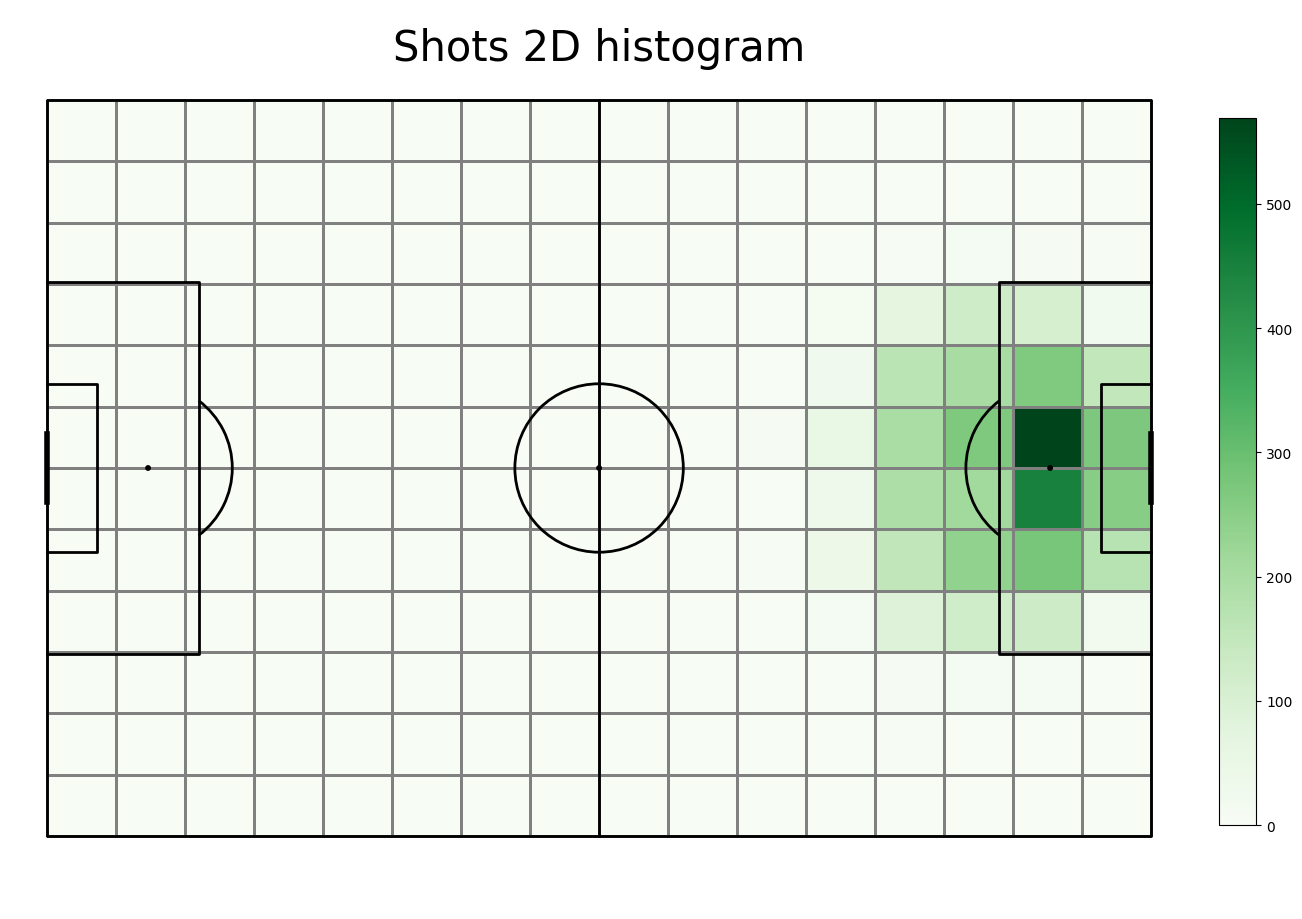

In [36]:
#get shot df
shot_df = xt_df.loc[xt_df['type_name'] == "Shot"]
# shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
# shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

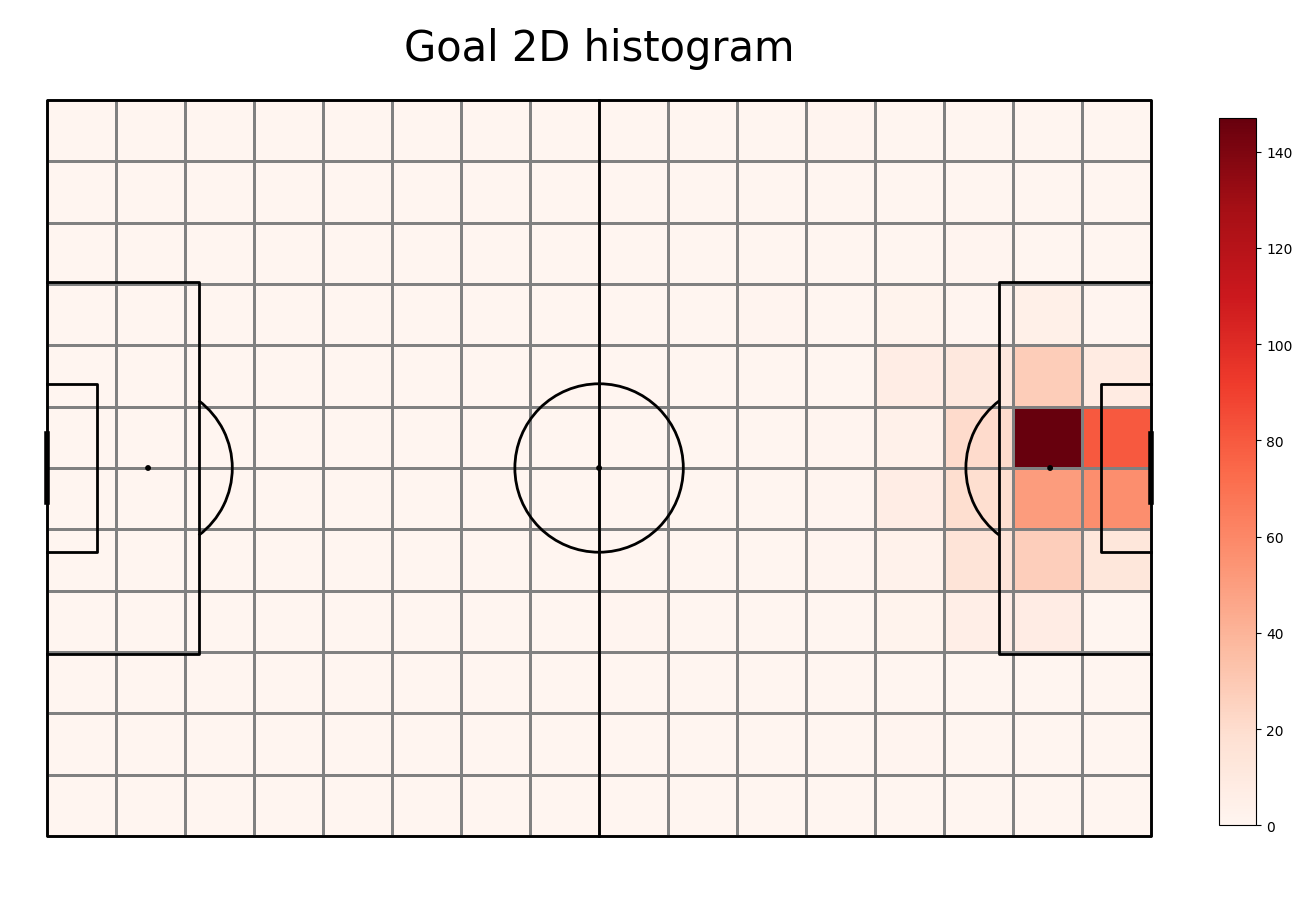

In [37]:
#get goal df
goal_df  = xt_df.loc[xt_df["outcome_name"] == "Goal"]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()


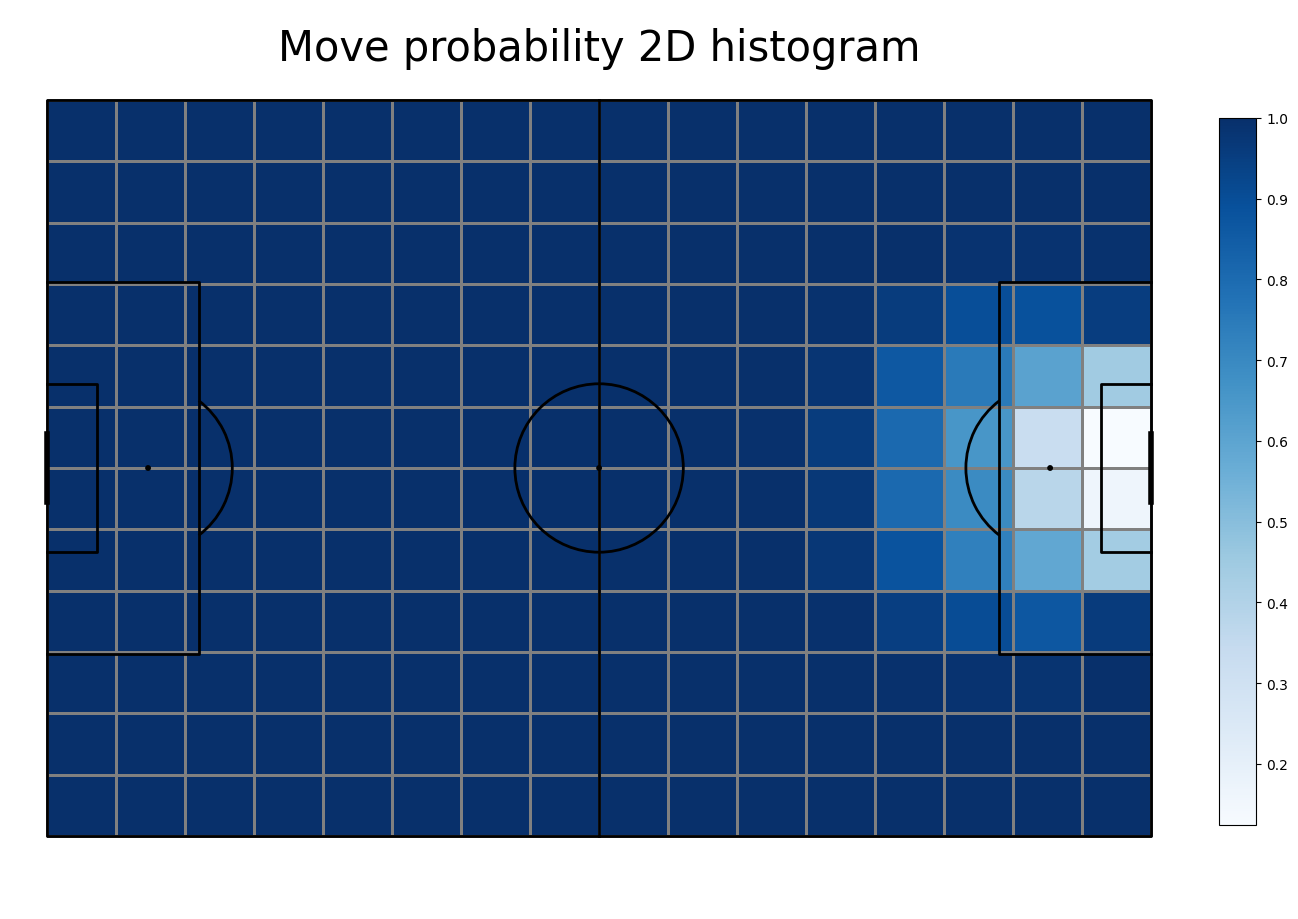

In [38]:
move_probability = move_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

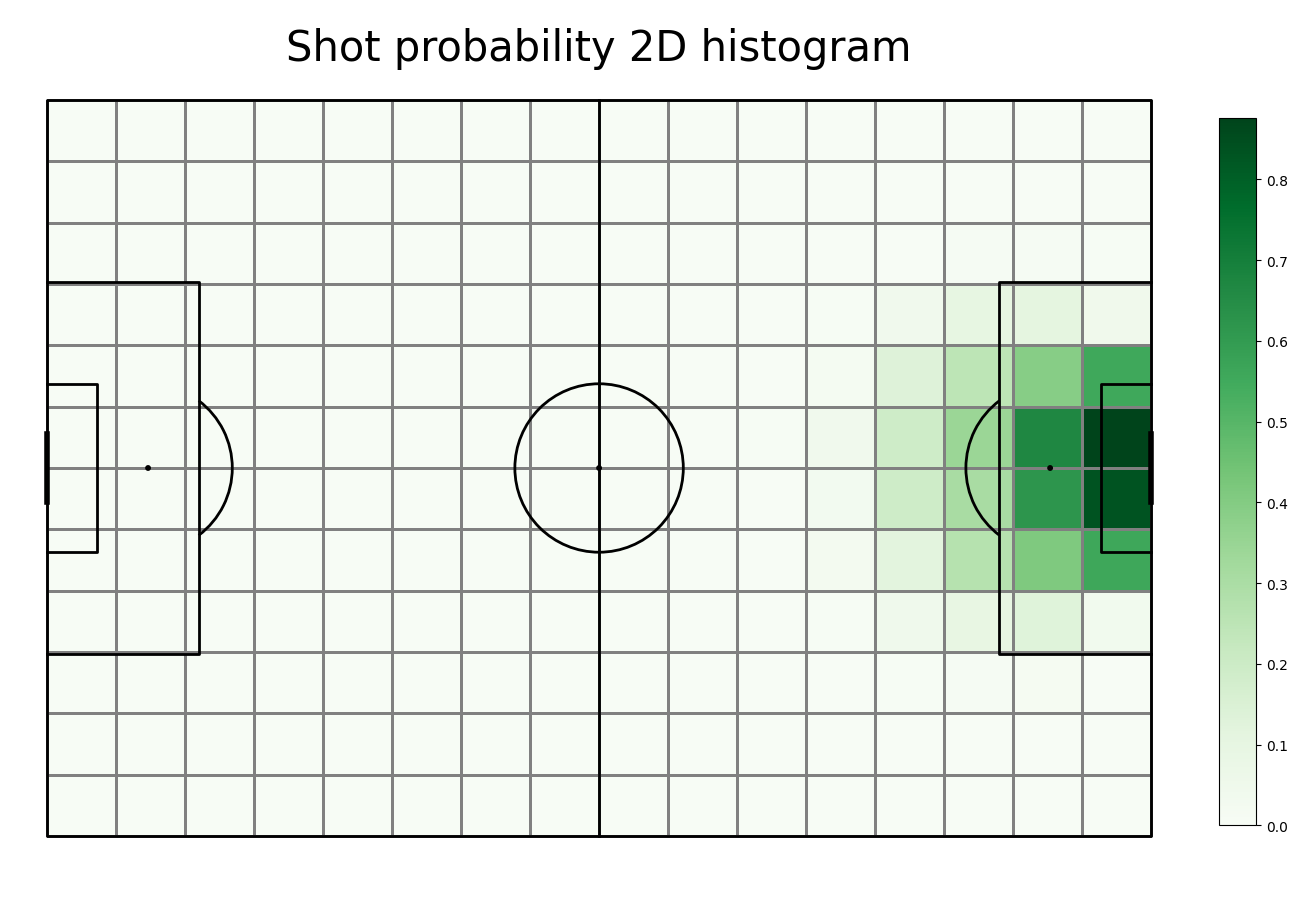

In [39]:
shot_probability = shot_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()


/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/1173137835.py:1: RuntimeWarning: invalid value encountered in divide
  goal_probability = goal_count/shot_count


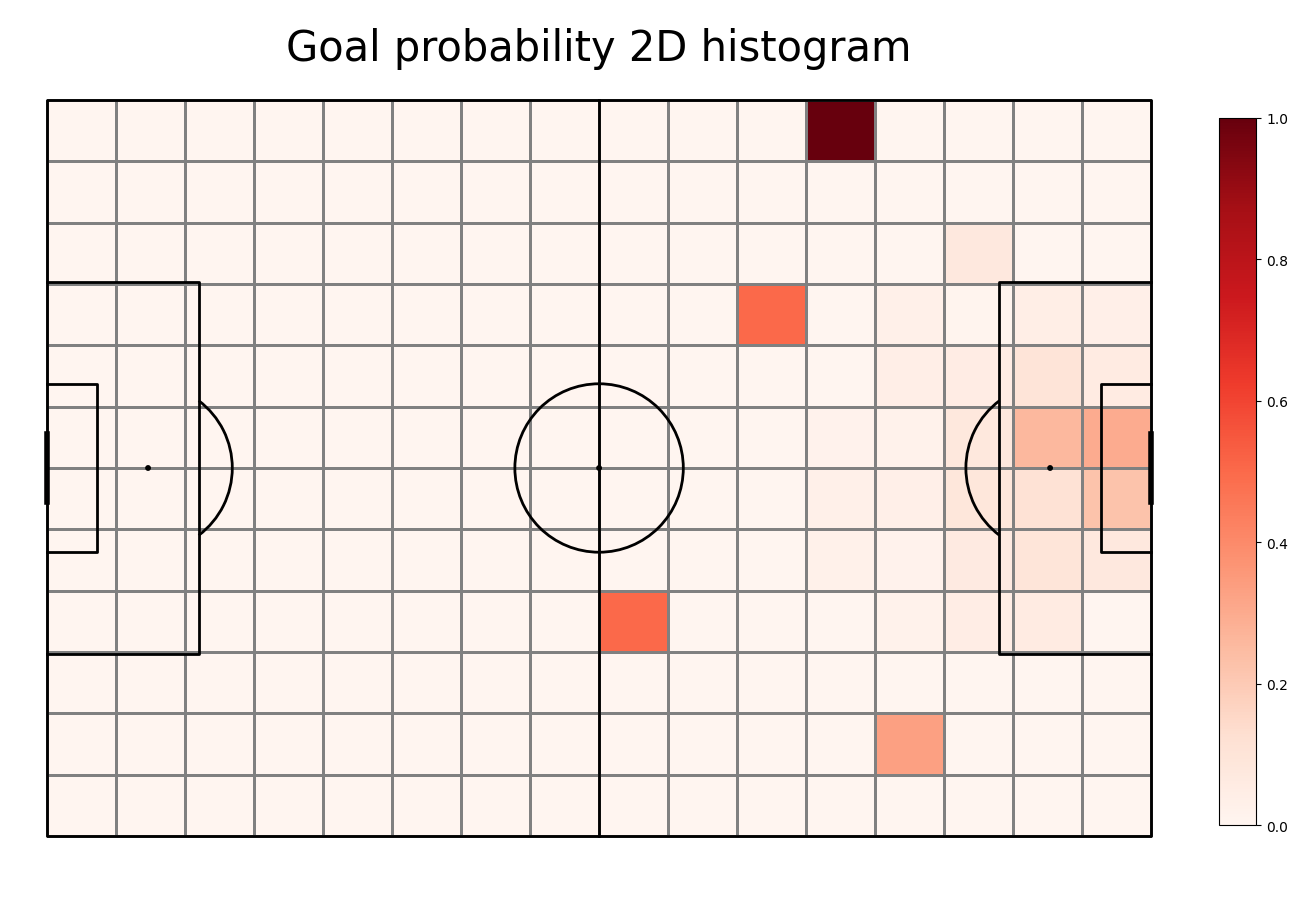

In [40]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

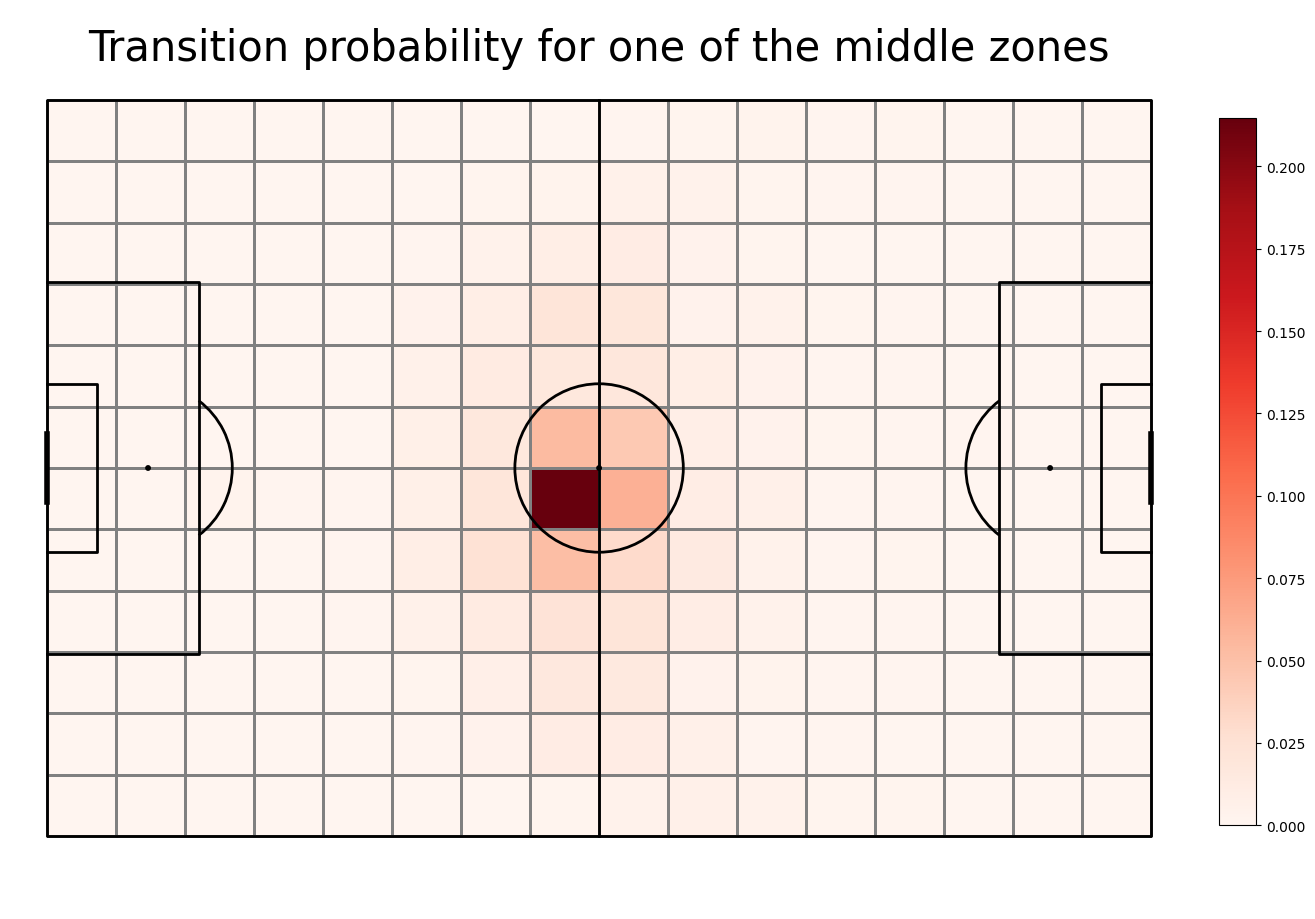

In [41]:
from scipy.stats import binned_statistic_2d

#move start index - using the same function as mplsoccer, it should work
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 120], [0, 80]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
#move end index
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 120], [0, 80]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

#df with summed events from each index
df_count_starts = move_df.groupby(["start_sector"])["id"].count().reset_index()
df_count_starts.rename(columns = {'id':'count_starts'}, inplace=True)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    #get all events that started in this sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_cound_ends = this_sector.groupby(["end_sector"])["id"].count().reset_index()
    df_cound_ends.rename(columns = {'id':'count_ends'}, inplace=True)
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_cound_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

#let's plot it for the zone [1,1] - left down corner
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#Change the index here to change the zone.
goal["statistic"] = transition_matrices[90]
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()

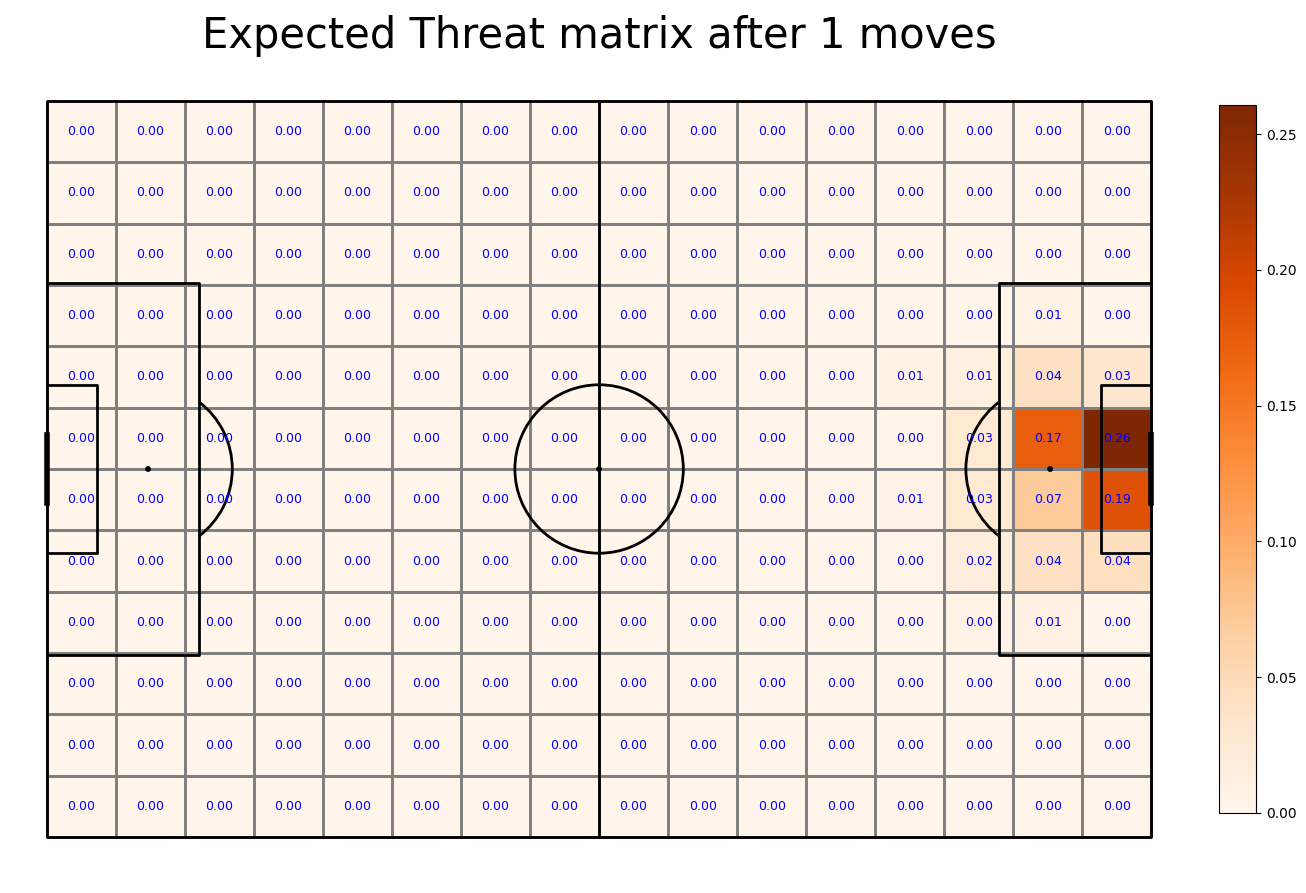

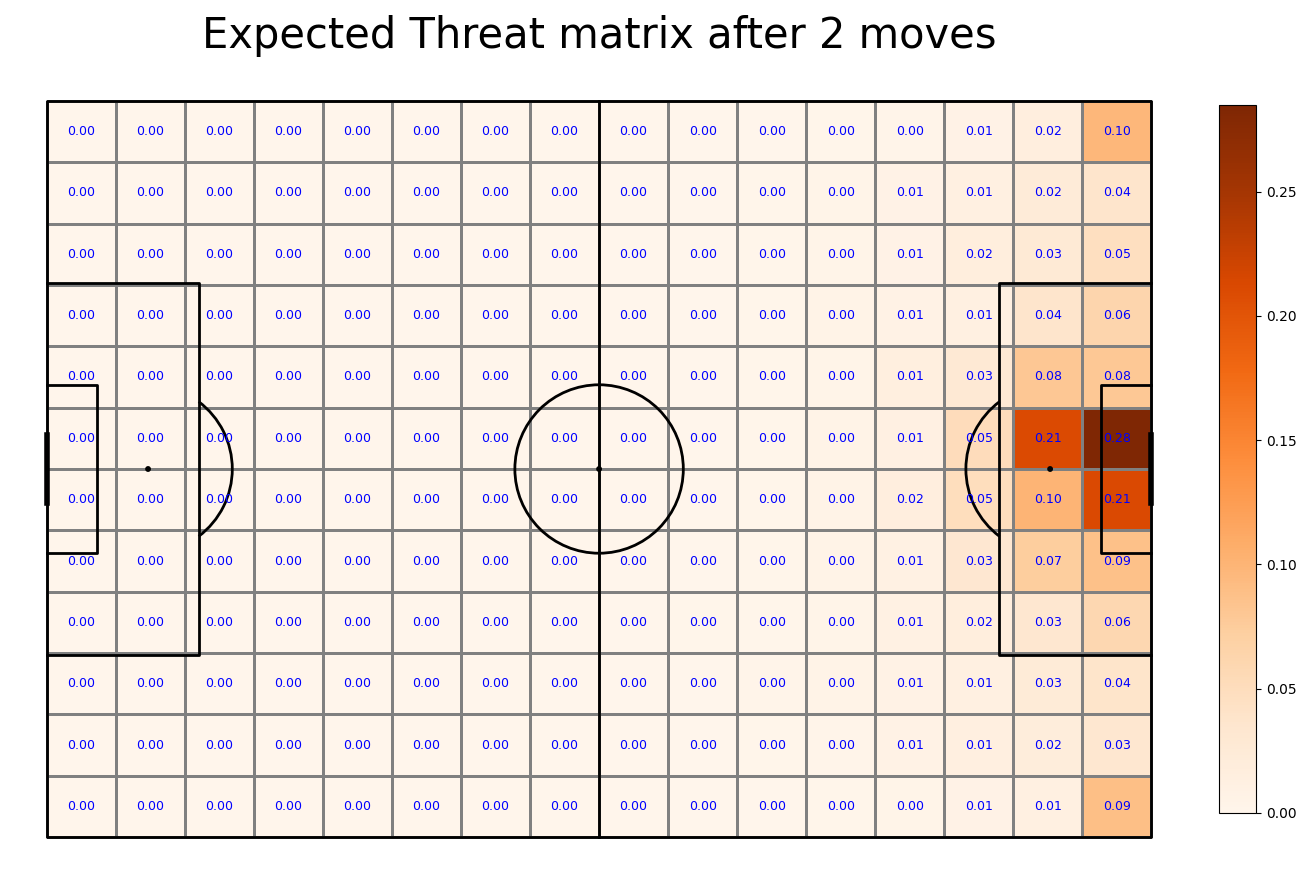

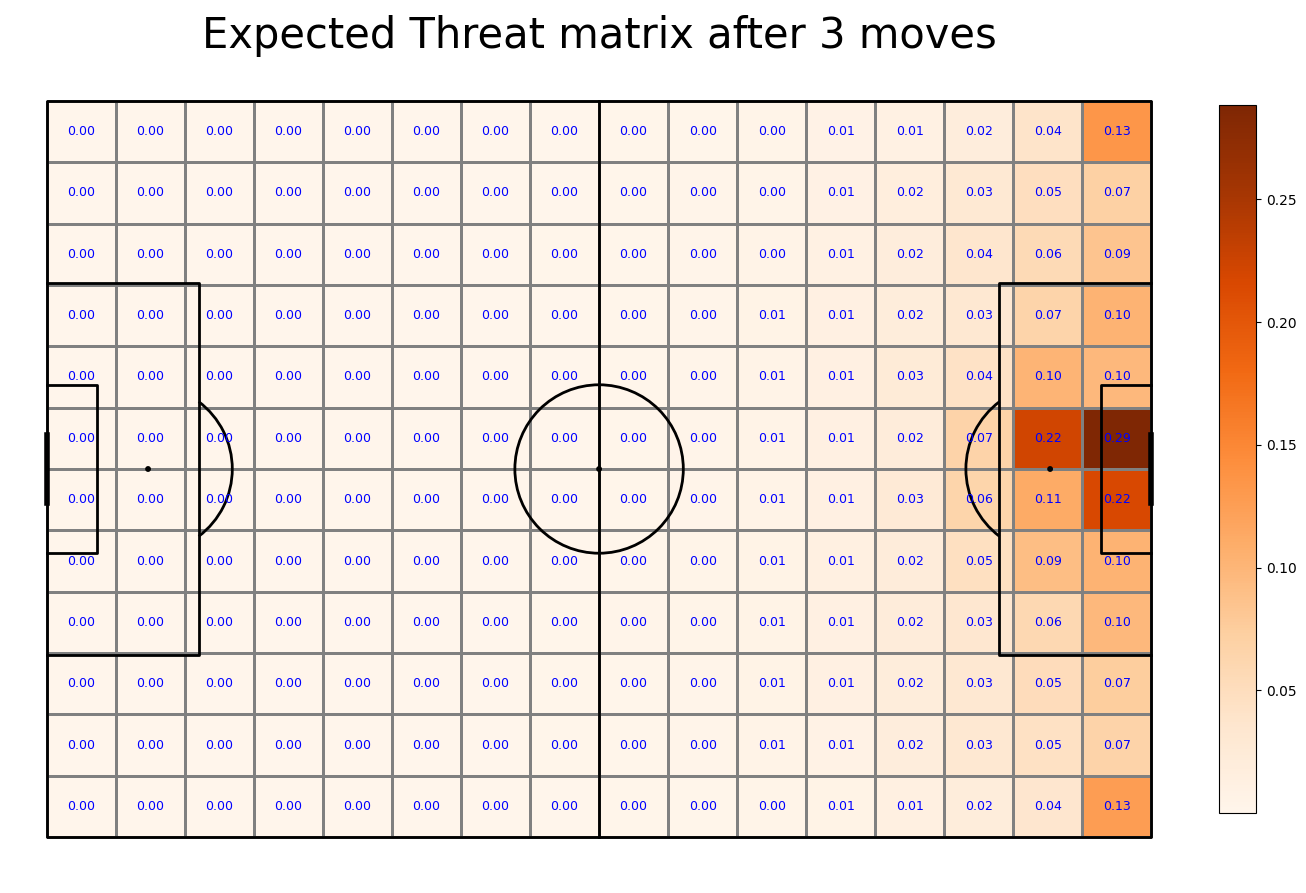

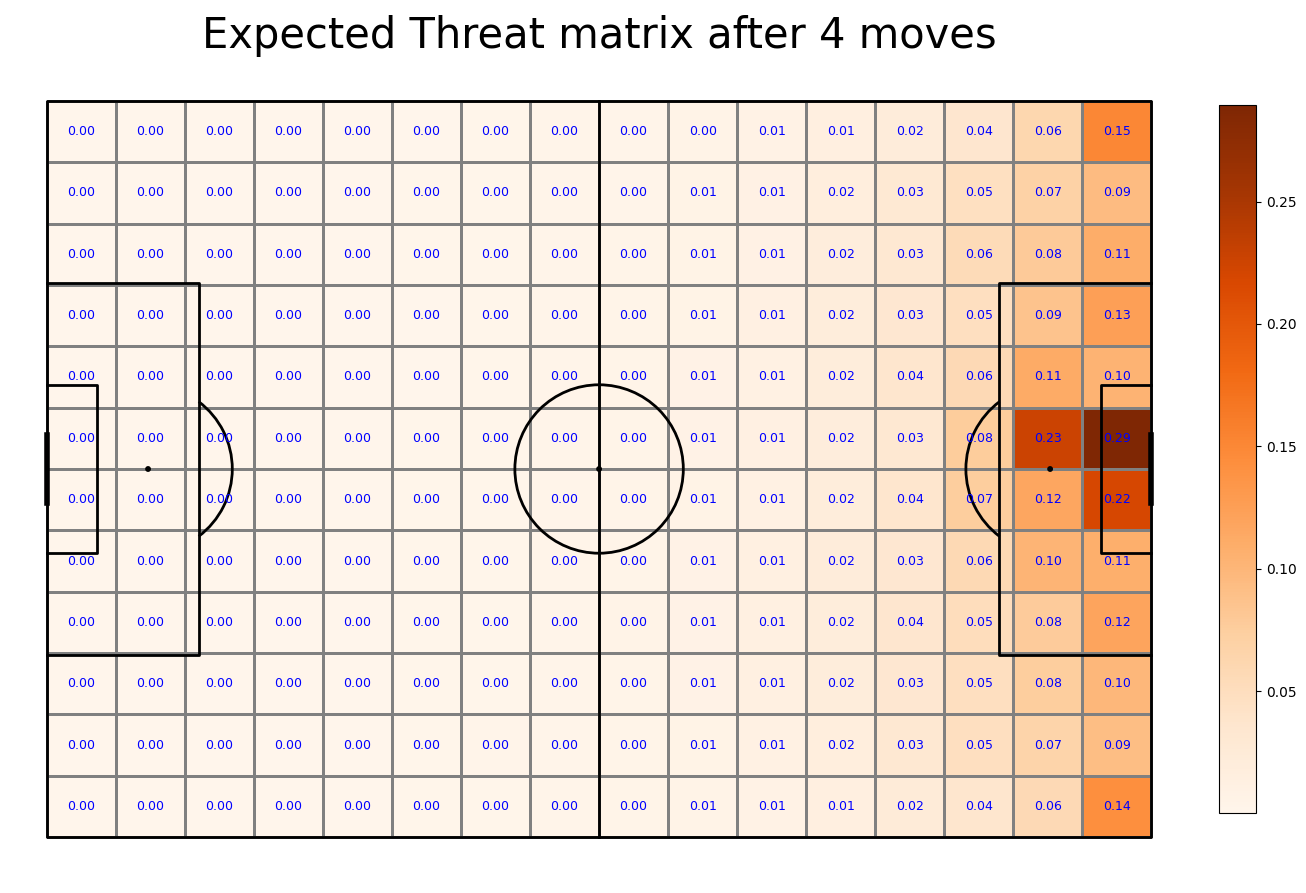

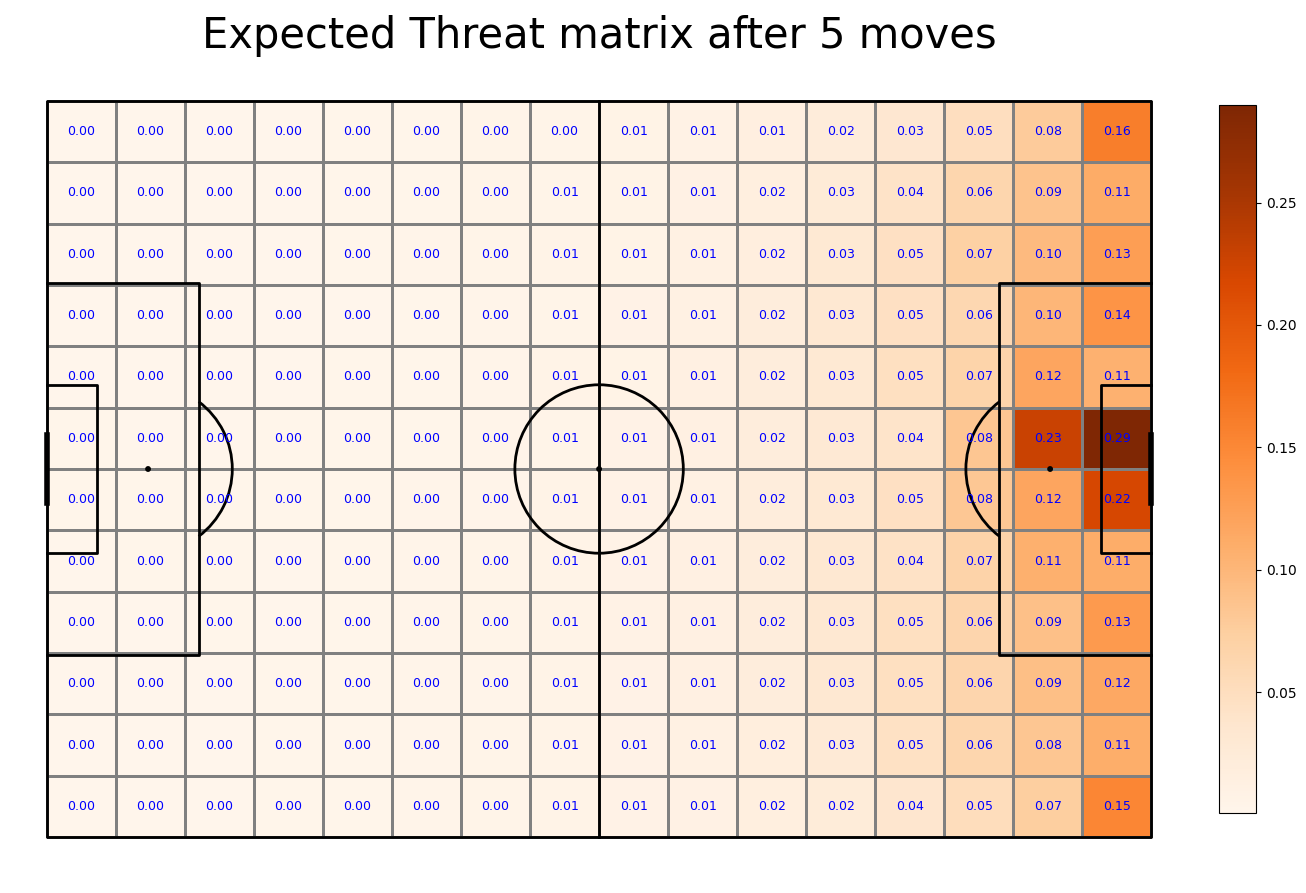

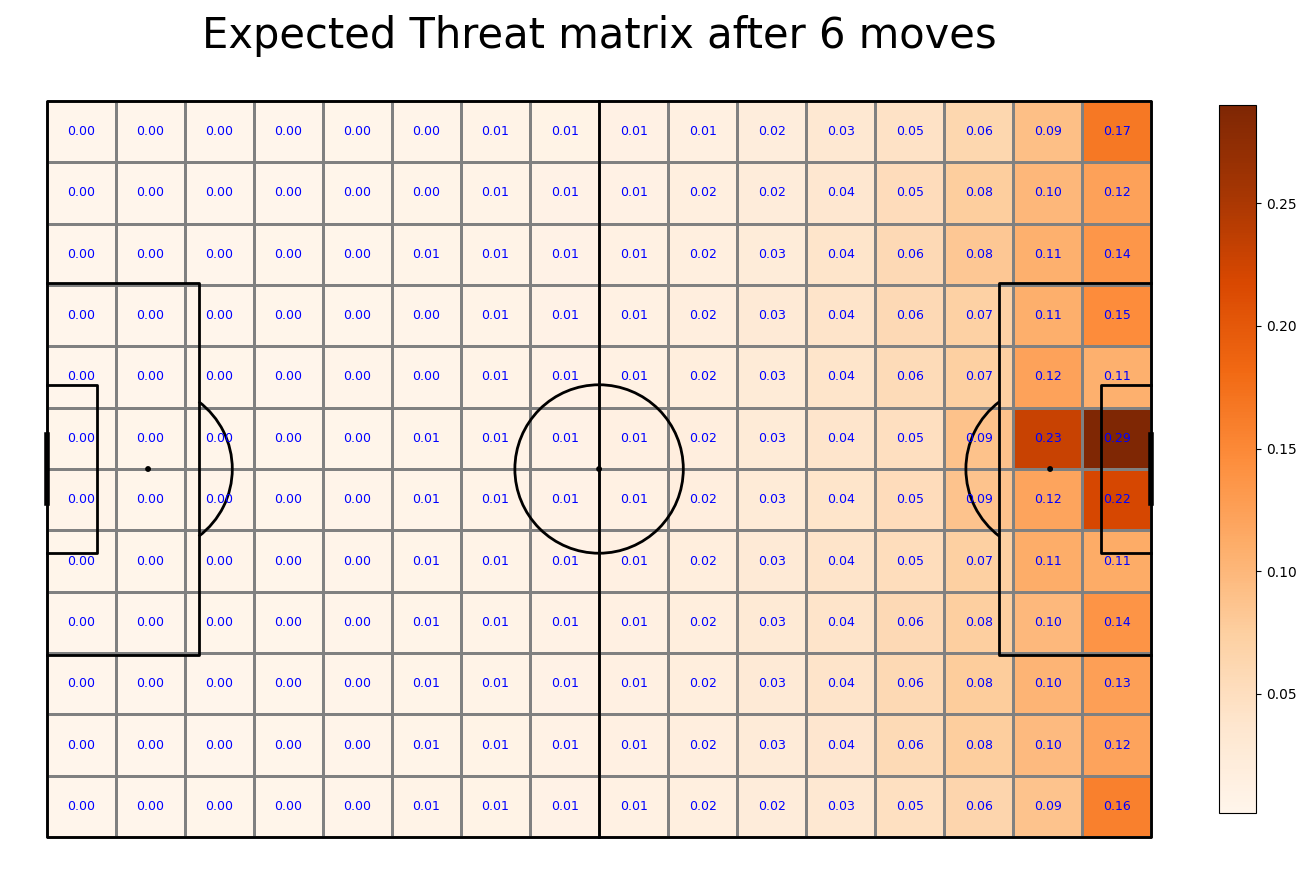

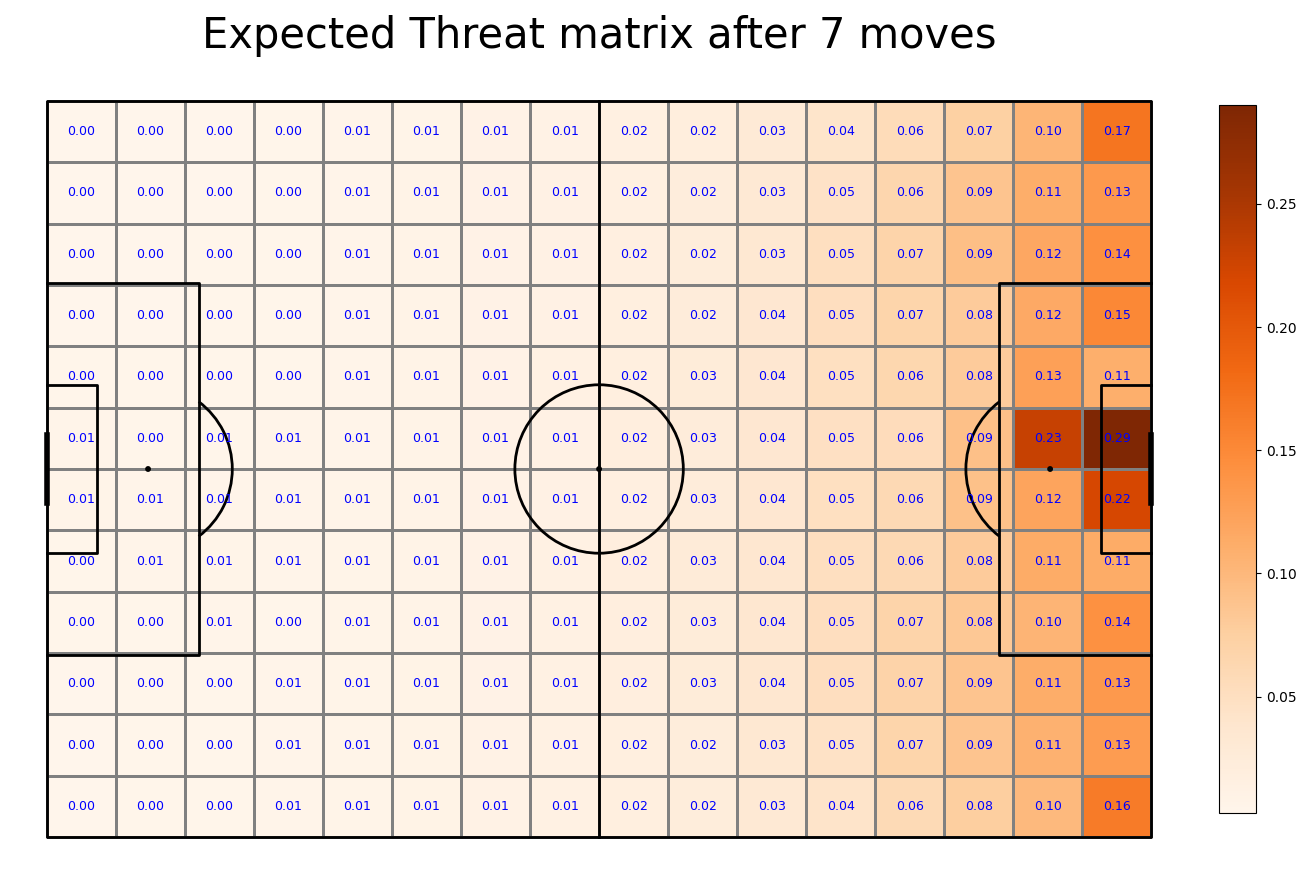

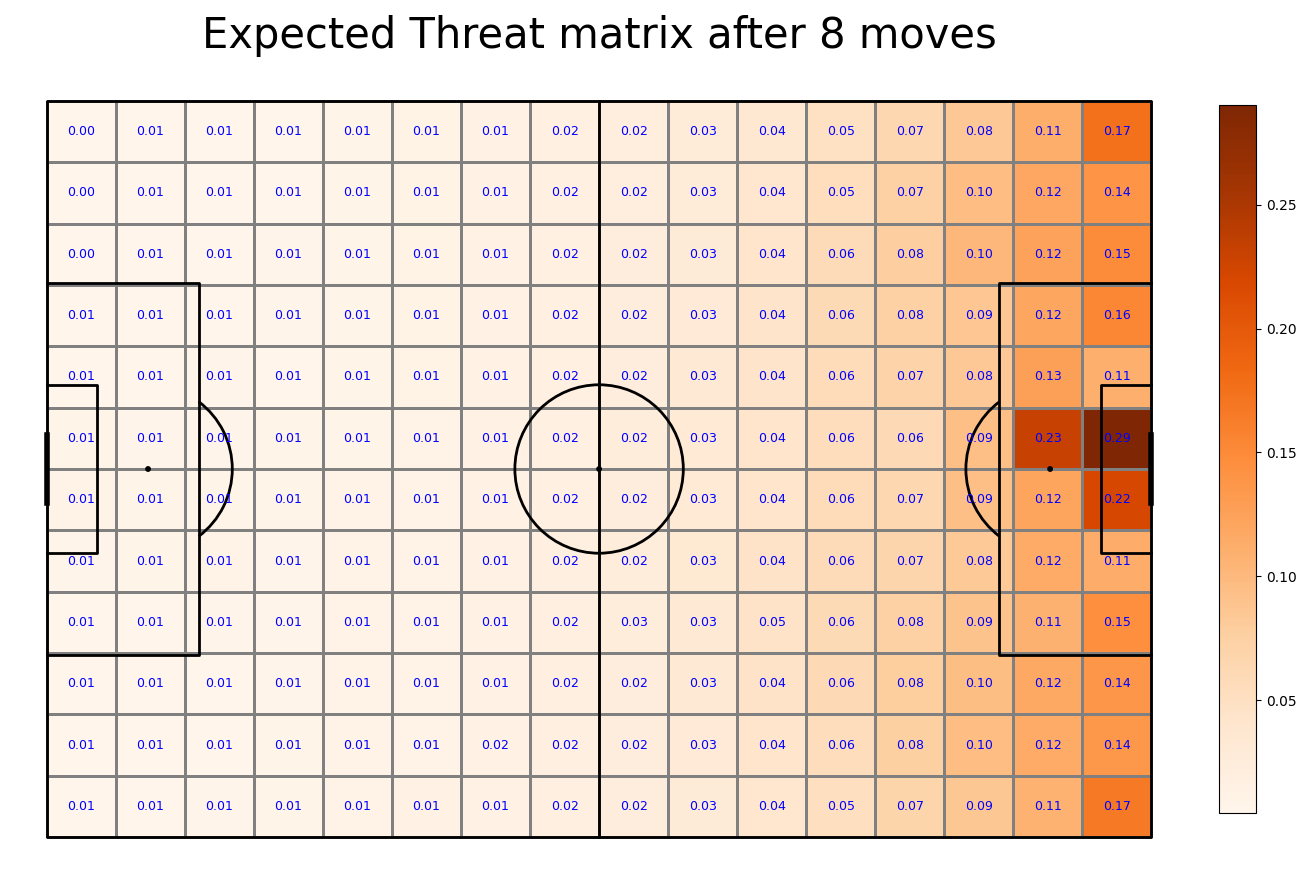

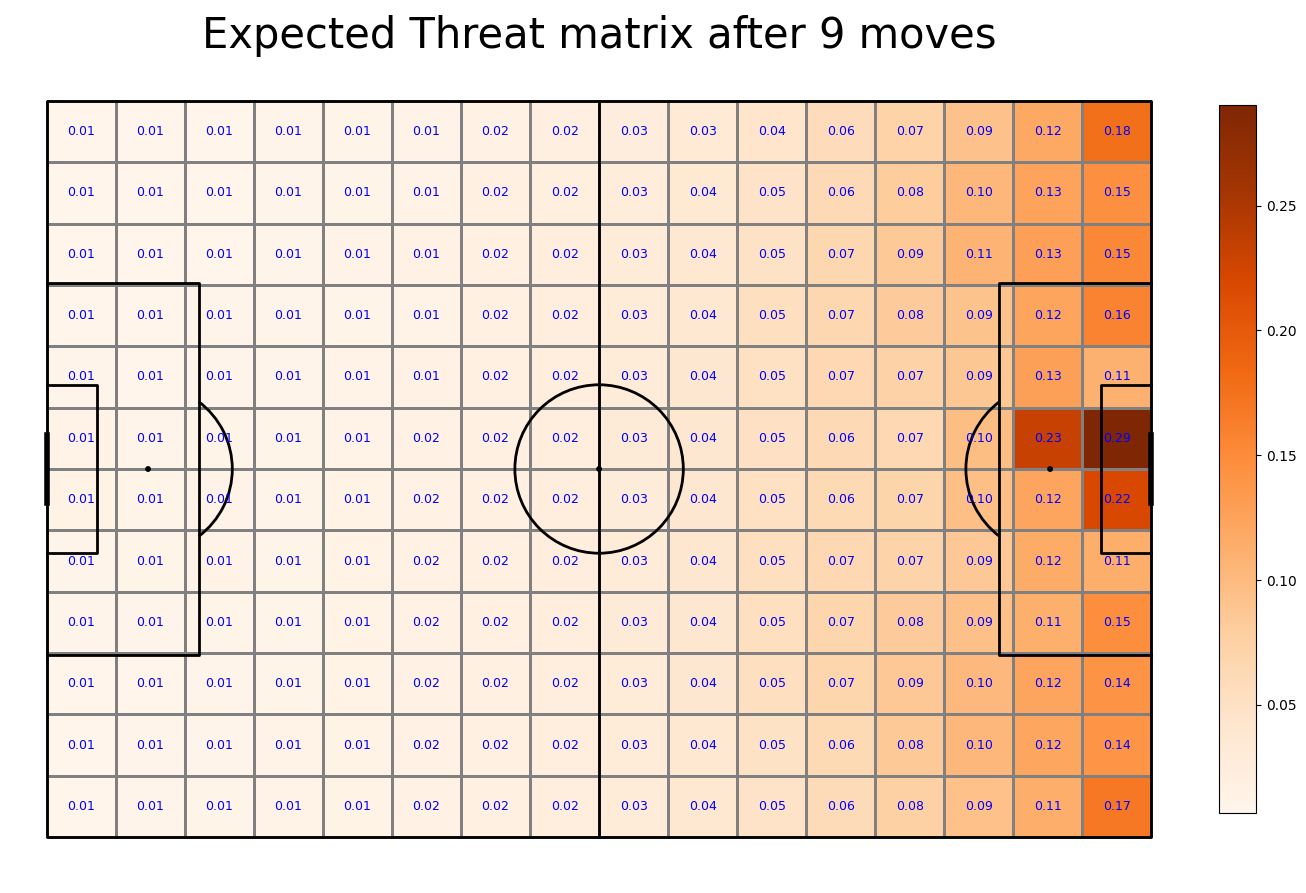

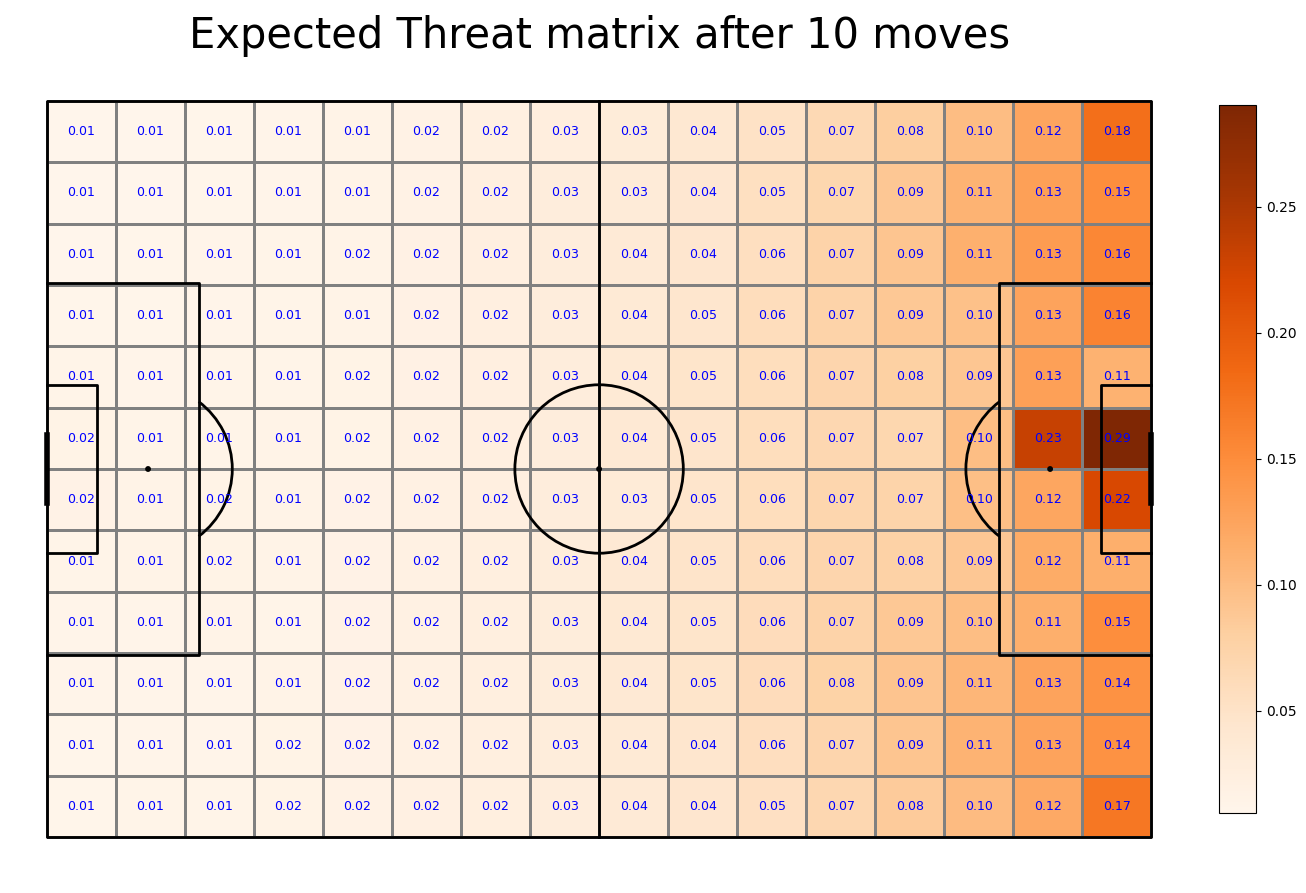

In [42]:
transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12, 16))
for i in range(10):
    shoot_expected_payoff = goal_probability*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.01, title_space=0, endnote_space=0)
    goal["statistic"] = xT
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

#### Take 2

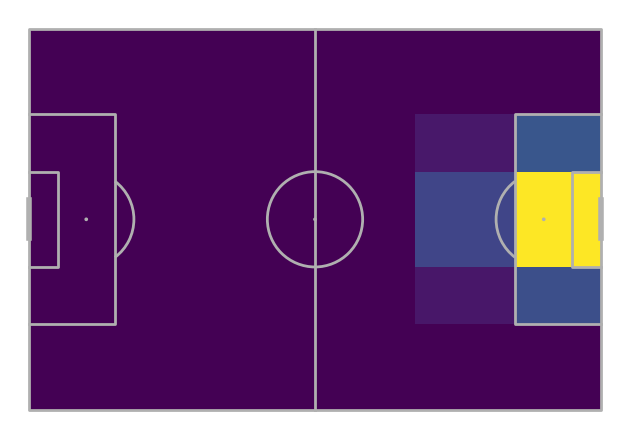

In [43]:
parser = Sbopen()
pitch = Pitch(line_zorder=2)

bins = (pitch.dim.positional_x[[0, 3, 4, 5, 6]], pitch.dim.positional_y)


event = xt_df.copy()

# boolean columns for working out probabilities
event['goal'] = event['outcome_name'] == 'Goal'
event['shoot'] = event['type_name'] == 'Shot'
event['move'] = event['type_name'] != 'Shot'

shot_probability = pitch.bin_statistic(event['x'], event['y'], values=event['shoot'],
                                       statistic='mean', bins=bins)
move_probability = pitch.bin_statistic(event['x'], event['y'], values=event['move'],
                                       statistic='mean', bins=bins)
goal_probability = pitch.bin_statistic(event.loc[event['shoot'], 'x'],
                                       event.loc[event['shoot'], 'y'],
                                       event.loc[event['shoot'], 'shot_statsbomb_xg'],
                                       statistic='mean',
                                       bins=bins)

fig, ax = pitch.draw()
shot_heatmap = pitch.heatmap(shot_probability, ax=ax)

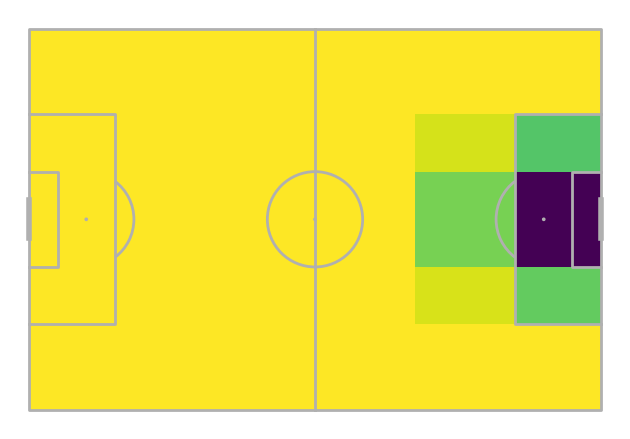

In [44]:
fig, ax = pitch.draw()
move_heatmap = pitch.heatmap(move_probability, ax=ax)

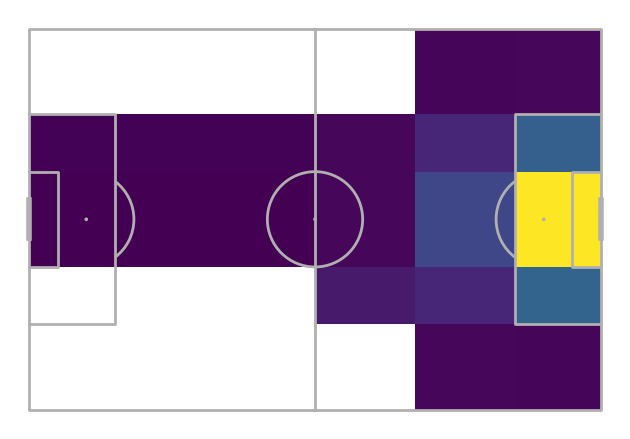

In [45]:
fig, ax = pitch.draw()
goal_heatmap = pitch.heatmap(goal_probability, ax=ax)

In [46]:
move = event[event['move']].copy()
bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)
move = move[bin_start_locations['inside']].copy()

# get the successful moves
bin_end_locations = pitch.bin_statistic(move['end_x'], move['end_y'], bins=bins)
move_success = move[(bin_end_locations['inside']) & (move['outcome_name'].isnull())].copy()

bin_success_start = pitch.bin_statistic(move_success['x'], move_success['y'], bins=bins)
bin_success_end = pitch.bin_statistic(move_success['end_x'], move_success['end_y'], bins=bins)
df_bin = pd.DataFrame({'x': bin_success_start['binnumber'][0],
                       'y': bin_success_start['binnumber'][1],
                       'end_x': bin_success_end['binnumber'][0],
                       'end_y': bin_success_end['binnumber'][1]})


# calculate the bin counts for the successful moves
bin_counts = df_bin.value_counts().reset_index(name='bin_counts')

# create the move_transition_matrix 
num_y, num_x = shot_probability['statistic'].shape
move_transition_matrix = np.zeros((num_y, num_x, num_y, num_x))
move_transition_matrix[bin_counts['y'], bin_counts['x'],
                       bin_counts['end_y'], bin_counts['end_x']] = bin_counts.bin_counts.values

# and divide by the starting locations for all moves (including unsuccessful)
# to get the probability of moving the ball successfully between grid cells
bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)
bin_start_locations = np.expand_dims(bin_start_locations['statistic'], (2, 3))
move_transition_matrix = np.divide(move_transition_matrix,
                                   bin_start_locations,
                                   out=np.zeros_like(move_transition_matrix),
                                   where=bin_start_locations != 0,
                                   )

In [47]:
move_transition_matrix = np.nan_to_num(move_transition_matrix)
shot_probability_matrix = np.nan_to_num(shot_probability['statistic'])
move_probability_matrix = np.nan_to_num(move_probability['statistic'])
goal_probability_matrix = np.nan_to_num(goal_probability['statistic'])

In [48]:
xt = np.multiply(shot_probability_matrix, goal_probability_matrix)
diff = 1
iteration = 0
while np.any(diff > 0.00001):  # iterate until the differences between the old and new xT is small
    xt_copy = xt.copy()  # keep a copy for comparing the differences
    # calculate the new expected threat
    xt = (np.multiply(shot_probability_matrix, goal_probability_matrix) +
          np.multiply(move_probability_matrix,
                      np.multiply(move_transition_matrix, np.expand_dims(xt, axis=(0, 1))).sum(
                          axis=(2, 3)))
          )
    diff = (xt - xt_copy)
    iteration += 1
print('Number of iterations:', iteration)


Number of iterations: 44


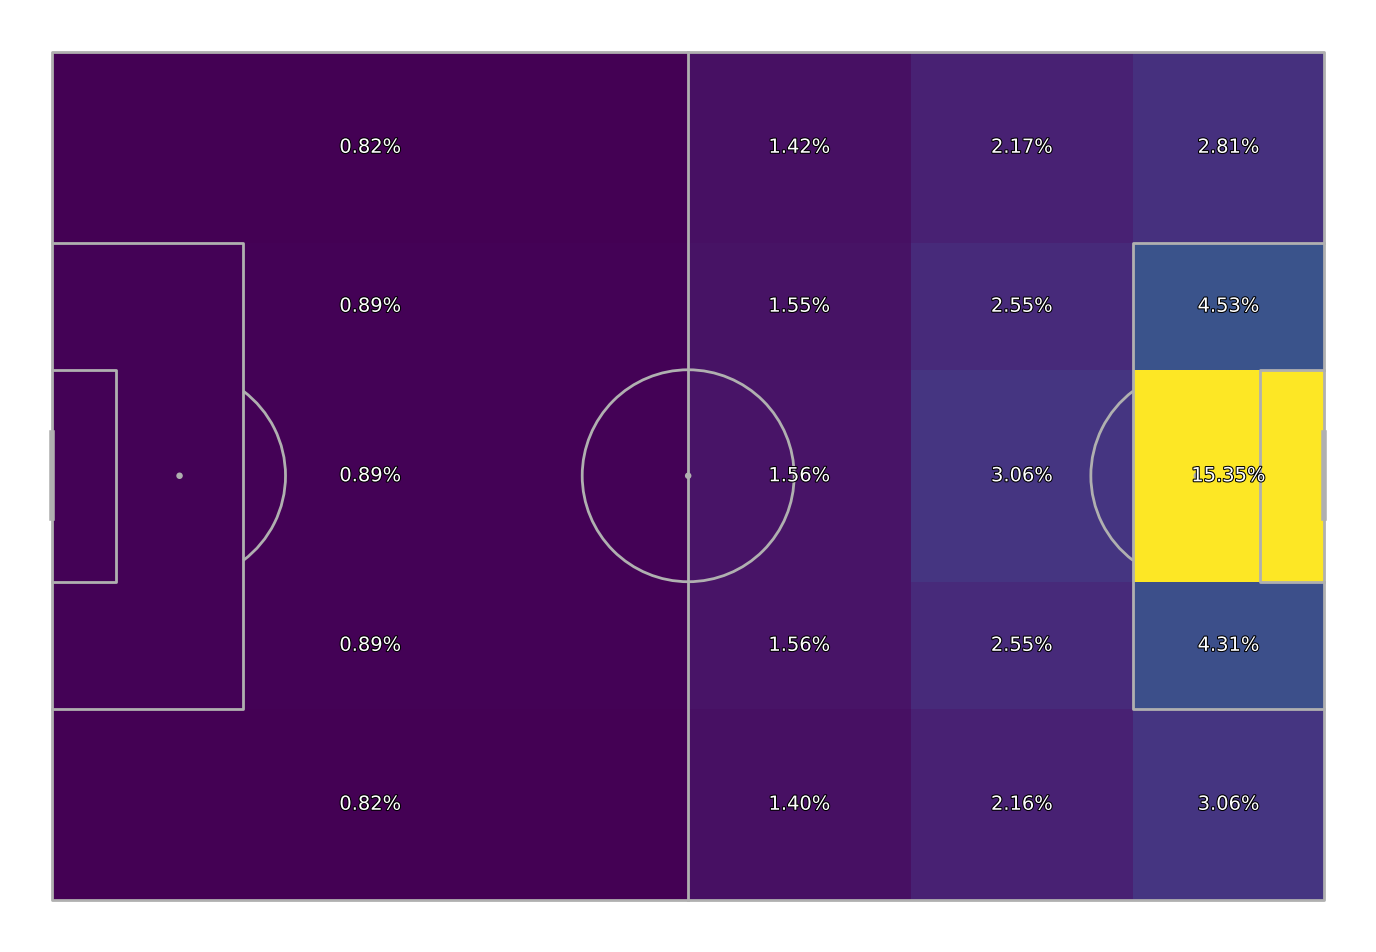

In [49]:
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]
# new bin statistic for plotting xt only
for_plotting = pitch.bin_statistic(event['x'], event['y'], bins=bins)
for_plotting['statistic'] = xt
fig, ax = pitch.draw(figsize=(14, 9.625))
_ = pitch.heatmap(for_plotting, ax=ax)
_ = pitch.label_heatmap(for_plotting, ax=ax, str_format='{:.2%}',
                        color='white', fontsize=14, va='center', ha='center',
                        path_effects=path_eff)

In [50]:
# first get grid start and end cells
grid_start = pitch.bin_statistic(move_success.x, move_success.y, bins=bins)
grid_end = pitch.bin_statistic(move_success.end_x, move_success.end_y, bins=bins)

# then get the xT values from the start and end grid cell
start_xt = xt[grid_start['binnumber'][1], grid_start['binnumber'][0]]
end_xt = xt[grid_end['binnumber'][1], grid_end['binnumber'][0]]

# then calculate the added xT
added_xt = end_xt - start_xt
move_success['xt'] = added_xt

In [51]:
# First group by comp_id and seas_id, then by player_name and sum their xT values
player_xt = (move_success.groupby(['comp_id', 'seas_id', 'player_name'])['xt']
             .sum()
             .reset_index())

# Then group by comp_id and seas_id and get top 5 players by xt value
top_players = (player_xt.groupby(['comp_id', 'seas_id'])
               .apply(lambda x: x.nlargest(5, 'xt'))
               .reset_index(drop=True))

# Sort the results for better readability
top_players = top_players.sort_values(['comp_id', 'seas_id', 'xt'], 
                                    ascending=[True, True, False])
top_players

/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/1113814520.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, 'xt'))


,comp_id,seas_id,player_name,xt
0,9,281,Alejandro Grimaldo García,8.291243
1,9,281,Florian Wirtz,7.510969
2,9,281,Jeremie Frimpong,6.743476
3,9,281,Granit Xhaka,5.181923
4,9,281,Jonas Hofmann,5.111888
5,55,43,Luke Shaw,1.928062
6,55,43,Joakim Mæhle,1.763808
7,55,43,Toni Kroos,1.531897
8,55,43,Jorge Resurrección Merodio,1.525640
9,55,43,Lorenzo Insigne,1.501668


### Results

In [53]:
# # Merge test_related and test_event
# xt_df = test_related_df[['match_id', 'id', 'index', 'type_name']].merge(
#     test_event_df[['match_id', 'id', 'index', 'type_name', 'possession_team_id', 'end_x', 'end_y', 'x', 'y', 'player_name','outcome_name']], 
#     on=['match_id', 'id', 'index', 'type_name'], how='left').sort_values(by=['match_id', 'index'])

# # Filter for Pass, Carry, and Shot
# xt_df = xt_df[xt_df["type_name"].isin(['Pass', 'Carry', 'Shot'])].reset_index(drop=True).drop_duplicates()

# # Identify Goal rows
# goal_locs = xt_df.index[xt_df["outcome_name"] == 'Goal']

# # Get pass_carry events
# how_many_rows_back = 8
# new_indices = pd.Index([])
# row_index = -1
# for goal_loc in goal_locs:
#     prev_index = row_index + 1
#     row_index = xt_df.index.get_loc(goal_loc)
#     new_indices = new_indices.union(xt_df.index[max(prev_index, row_index - how_many_rows_back):row_index + 1])
# pass_carry_df = xt_df.loc[new_indices].drop_duplicates().reset_index(drop=True)

# # backfill
# pass_carry_df['group'] = pass_carry_df['group'].bfill()
# goal_locs = xt_df.index[xt_df["outcome_name"] == 'Goal']
# xt_df['group'] = pd.NA
# xt_df.loc[goal_locs, 'group'] = range(1, len(goal_locs) + 1)

KeyError: 'group'

In [54]:
# Merge test_related and test_event
xt_df = test_related_df[['match_id', 'id', 'index', 'type_name']].merge(
    test_event_df[['match_id', 'id', 'index', 'type_name', 'possession_team_id', 'end_x', 'end_y', 'x', 'y', 'player_name','outcome_name']], 
    on=['match_id', 'id', 'index', 'type_name'], how='left').sort_values(by=['match_id', 'index'])

# Filter for Pass, Carry, and Shot
xt_df = xt_df[xt_df["type_name"].isin(['Pass', 'Carry', 'Shot'])].reset_index(drop=True).drop_duplicates()

# Identify Goal rows
goal_locs = xt_df.index[xt_df["outcome_name"] == 'Goal']
# print(xt_df.loc[goal_locs].head(5))
xt_df['group'] = pd.NA
xt_df.loc[goal_locs, 'group'] = range(1, len(goal_locs) + 1)

how_many_rows_back = 8
prev_goal_index = -1 
pass_carry_df = pd.DataFrame()
for goal_index in goal_locs:
    start_index = max(prev_goal_index + 1, goal_index - how_many_rows_back)
    
    events = xt_df.loc[start_index:goal_index]
    def_half_events = list(events.index[events.end_x < 50])
    valid_events = events if not def_half_events else events.loc[def_half_events[-1]+1:]
    
    pass_carry_df = pd.concat([pass_carry_df, valid_events])
    
    prev_goal_index = goal_index

# Reset index and assign groups
pass_carry_df = pass_carry_df.reset_index(drop=True)
pass_carry_df['group'] = pass_carry_df['group'].bfill()

/var/folders/y6/sbm28jw975q8__vq0y26t_tc0000gn/T/ipykernel_9380/3273766217.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pass_carry_df['group'] = pass_carry_df['group'].bfill()


In [ ]:
# pass_carry_df.head(10)

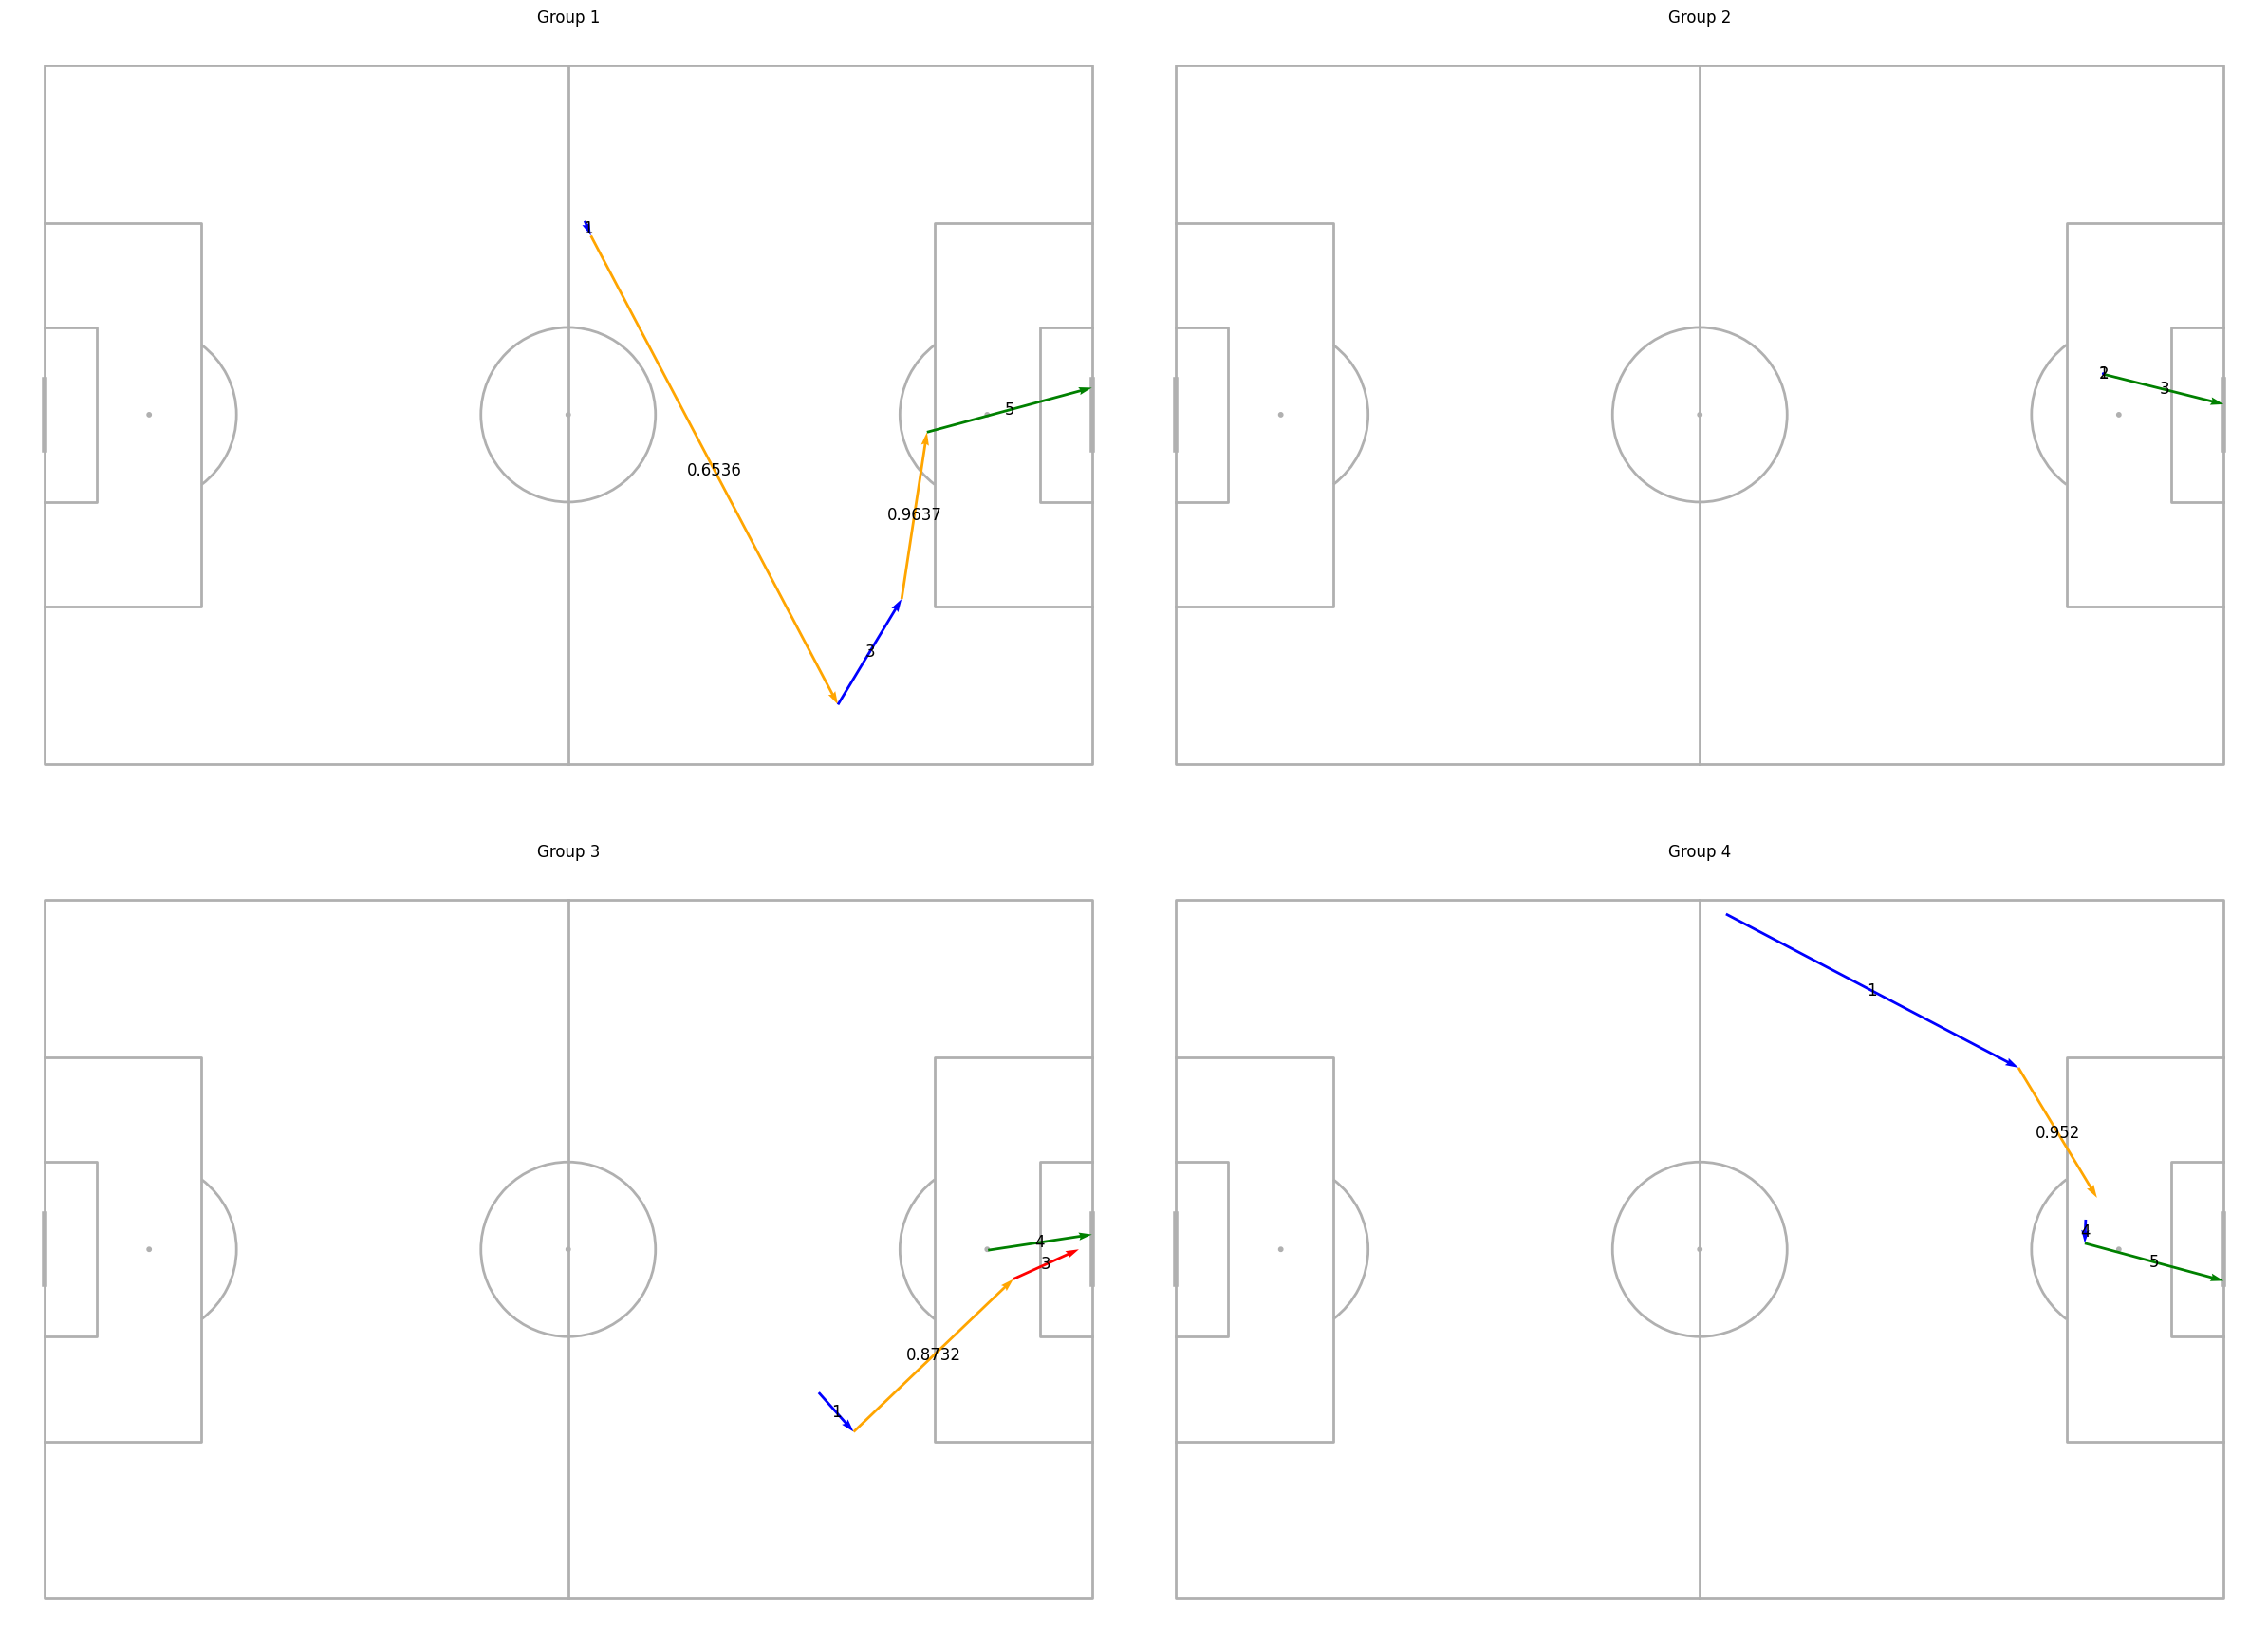

In [55]:
# Define colors for different types of events
color_map = {
    'Goal': 'green',
    'Shot': 'red',
    'Carry': 'blue',
    'Pass': 'orange',
}
# for index_ in range(len(best_models)):
for index_ in range(5,6):
    # Map the probabilities
    # id_to_probability = dict(zip(test_clean_pass_df['id'], new_probs[index_]))
    id_to_probability = dict(zip(test_clean_pass_df['id'], predicted_prob))
    
    # Create a pitch
    pitch = Pitch(pitch_type='statsbomb')
    
    # Grid of images
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(24, 18))
    axs = axs.flatten()
    
    for ax_index, (ax, (group_number, group_df)) in enumerate(zip(axs[:len(pass_carry_df['group'].unique())], pass_carry_df.groupby('group'))):
        pitch.draw(ax=ax)
    
        goal_team_id = group_df.loc[group_df['outcome_name'] == 'Goal', 'possession_team_id'].iloc[0]
        
        # Iterate over events with index tracking
        event_indices = group_df.index.tolist()
        for i, (_, event) in enumerate(group_df.iterrows(), start=1):
            
            if event['possession_team_id'] != goal_team_id:
                continue
            
            # Check if the current event should be skipped
            if i < len(event_indices) - 1:
                next_event_index = group_df.loc[event_indices[i], 'index']
                current_event_index = event['index']
                if next_event_index - current_event_index > 3:
                    continue
            
            x, y = event['x'], event['y']
            end_x, end_y = event['end_x'], event['end_y']
            event_type = event['type_name']
            outcome = event['outcome_name']
            event_id = event['id']
    
            if event_id in id_to_probability:
                i = round(id_to_probability[event_id], 4)
            
            color = 'green' if outcome == 'Goal' else color_map[event_type]
            
            pitch.arrows(x, y, end_x, end_y, ax=ax, color=color, width=2)
            ax.text((x + end_x) / 2, (y + end_y) / 2, str(i), fontsize=12,
                    ha='center', va='center', color='black')
        
        ax.set_title(f'Group {group_number}')
    
    # Hide any unused subplots
    for ax in axs[len(pass_carry_df['group'].unique()):]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.savefig(f"Model #{index_+1}.png")
    plt.show()

### Voronoi (Space Creation)

In [69]:
# get freeze frame data for game 3788741
parser = Sbopen()
frames, visible = parser.frame(3930158)
# frames

In [70]:
# frame_idx = 20
# frame_id = visible.iloc[20].id

# visible_area = np.array(visible.iloc[frame_idx].visible_area).reshape(-1, 2)
# player_position_data = frames[frames.id == frame_id]

# teammate_locs = player_position_data[player_position_data.teammate]
# opponent_locs = player_position_data[~player_position_data.teammate]

visible_area = np.array(np.array(visible[visible.id == '0badc984-28cb-4036-9b0e-89ea7fc6820f'].visible_area)[0]).reshape(-1,2)
player_position_data = frames[frames.id == '0badc984-28cb-4036-9b0e-89ea7fc6820f']

teammate_locs = player_position_data[player_position_data.teammate]
opponent_locs = player_position_data[~player_position_data.teammate]

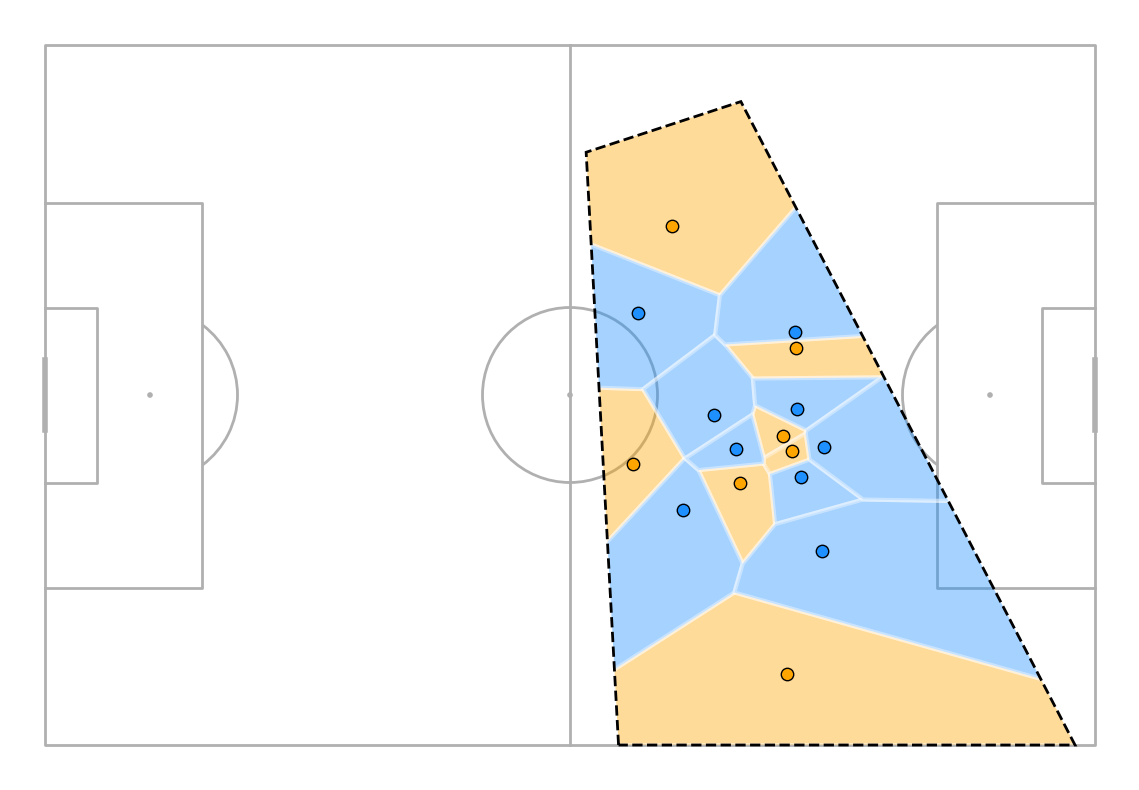

In [71]:
# draw plot
p = Pitch(pitch_type='statsbomb')
fig, ax = p.draw(figsize=(12,8))

# Plot Voronoi
team1, team2 = p.voronoi(player_position_data.x, player_position_data.y,
                         player_position_data.teammate)
t1 = p.polygon(team1, ax=ax, fc='orange', ec='white', lw=3, alpha=0.4)
t2 = p.polygon(team2, ax=ax, fc='dodgerblue', ec='white', lw=3, alpha=0.4)

# Plot players
sc1 = p.scatter(teammate_locs.x, teammate_locs.y, c='orange', s=80, ec='k', ax=ax)
sc2 = p.scatter(opponent_locs.x, opponent_locs.y, c='dodgerblue', s=80, ec='k', ax=ax)

# Plot the visible area
visible = p.polygon([visible_area], color='None', ec='k', linestyle='--', lw=2, ax=ax)

# clip each player to the visible area
for p1 in t1:
    p1.set_clip_path(visible[0])
for p2 in t2:
    p2.set_clip_path(visible[0])

plt.show()